In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             classification_report, roc_auc_score)
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette("husl")

In [4]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.drop('id',axis=1,inplace=True)
df = df[df["gender"] != "Other"]

In [5]:
print("="*80)
print("1. VERİ SETİ BİLGİLERİ")
print("="*80)

print("\n📊 Veri Seti Boyutu:")
print(f"Satır sayısı: {df.shape[0]}")
print(f"Sütun sayısı: {df.shape[1]}")

print("\n📋 İlk 5 Satır:")
print(df.head())

print("\n🔍 Sütun Bilgileri:")
print(df.info())
print("\n📈 İstatistiksel Özet:")
print(df.describe())

print("\n🏷️ Sütun Adları:")
print(df.columns.tolist())

1. VERİ SETİ BİLGİLERİ

📊 Veri Seti Boyutu:
Satır sayısı: 5109
Sütun sayısı: 11

📋 İlk 5 Satır:
   gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1  

🔍 Sütun Bilgileri:
<class 'panda

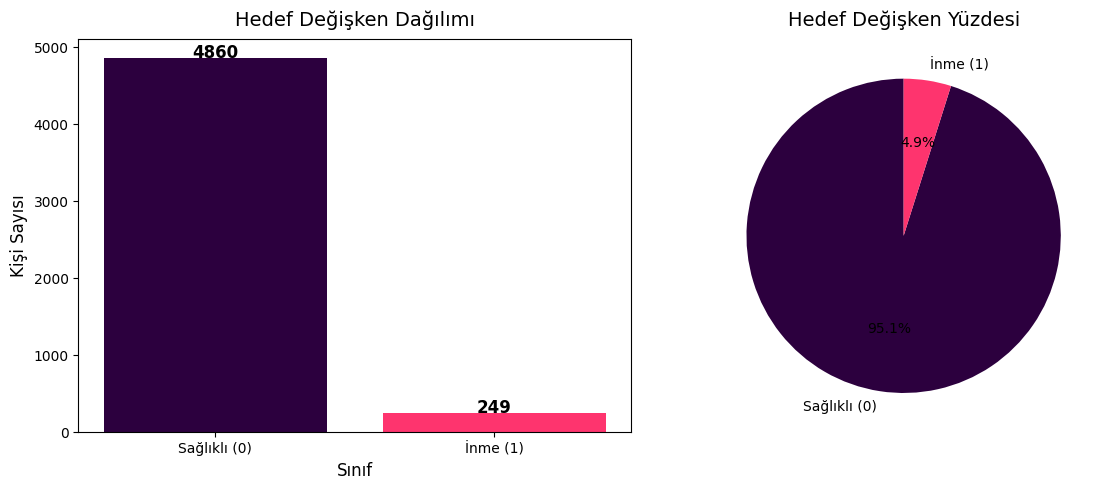


📊 Hedef Değişken Dağılımı:
Sağlıklı (0): 4860 (95.1%)
İnme (1): 249 (4.9%)


In [6]:
# Hedef değişken dağılımı

plt.figure(figsize=(12, 5))
stroke_counts = df['stroke'].value_counts().sort_index()
plt.subplot(1, 2, 1)
plt.bar(['Sağlıklı (0)', 'İnme (1)'], stroke_counts.values, color=['#2c003e', '#fe346e'])
plt.title('Hedef Değişken Dağılımı', fontsize=14, pad=10)
plt.ylabel('Kişi Sayısı', fontsize=12)
plt.xlabel('Sınıf', fontsize=12)

for i, v in enumerate(stroke_counts.values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=12, fontweight='bold')

plt.subplot(1, 2, 2)
plt.pie(stroke_counts.values, labels=['Sağlıklı (0)', 'İnme (1)'], autopct='%1.1f%%',
        colors=['#2c003e', '#fe346e'], startangle=90)
plt.title('Hedef Değişken Yüzdesi', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

print("\n📊 Hedef Değişken Dağılımı:")
print(f"Sağlıklı (0): {stroke_counts[0]} ({stroke_counts[0]/len(df)*100:.1f}%)")
print(f"İnme (1): {stroke_counts[1]} ({stroke_counts[1]/len(df)*100:.1f}%)")

/tmp/ipython-input-326304064.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(stroke_gen.index, **font_dict)
/tmp/ipython-input-326304064.py:71: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(healthy_gen.index, **font_dict)
/tmp/ipython-input-326304064.py:82: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(healthy_gen.index, **font_dict)
/tmp/ipython-input-326304064.py:93: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(healthy_gen.index,**font_dict)
/tmp/ipython-input-326304064.py:104: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after se

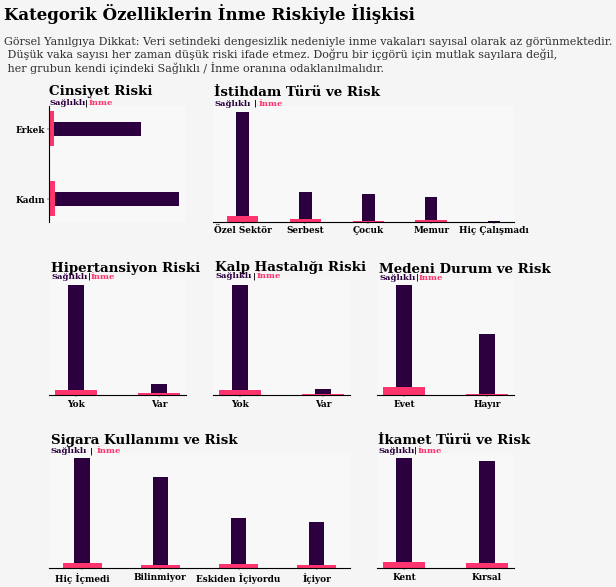

In [7]:
df_viz = df.copy()

df_viz['gender'] = df_viz['gender'].replace({'Male': 'Erkek', 'Female': 'Kadın'})
df_viz['work_type'] = df_viz['work_type'].replace({
    'Private': 'Özel Sektör', 'Self-employed': 'Serbest',
    'Govt_job': 'Memur', 'children': 'Çocuk', 'Never_worked': 'Hiç Çalışmadı'
})
df_viz['Residence_type'] = df_viz['Residence_type'].replace({'Urban': 'Kent', 'Rural': 'Kırsal'})
df_viz['smoking_status'] = df_viz['smoking_status'].replace({
    'formerly smoked': 'Eskiden İçiyordu', 'never smoked': 'Hiç İçmedi',
    'smokes': 'İçiyor', 'Unknown': 'Bilinmiyor'
})
df_viz['ever_married'] = df_viz['ever_married'].replace({'Yes': 'Evet', 'No': 'Hayır'})
df_viz['heart_disease'] = df_viz['heart_disease'].replace({0: 'Yok', 1: 'Var'})
df_viz['hypertension'] = df_viz['hypertension'].replace({0: 'Yok', 1: 'Var'})


fig = plt.figure(figsize = (15,15), dpi = 40)
gs = fig.add_gridspec(3,3)
gs.update(wspace = 0.2, hspace = 0.5)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1:])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])
ax6 = fig.add_subplot(gs[2,0:2])
ax7 = fig.add_subplot(gs[2,2])

axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7]
fig.patch.set_facecolor('#f5f5f5')

# Eksen ayarları
for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f8f8f8')
    ax.spines['bottom'].set_linewidth(2)
    for loc in ['left', 'right', 'top']:
        ax.spines[loc].set_visible(False)
        ax.spines[loc].set_linewidth(2)

# Yazı tipleri ve Renkler
title_args = {'font':'Serif', 'weight':'bold','color': 'black', 'size':24}
font_dict = {'size':16, 'family':'Serif', 'color':'black', 'weight':'bold'}
health_dict = {'font':'Serif', 'color': '#2c003e', 'size':15, 'weight':'bold'}
dash_dict = {'font':'Serif', 'color': 'black', 'size':15,'weight':'bold'}
stroke_dict = {'font':'Serif', 'color': '#fe346e', 'size':15,'weight':'bold'}
stroke_col = '#fe346e'
healthy_col = '#2c003e'

# Ax1: Cinsiyet (Gender)
healthy_gen = df_viz[df_viz['stroke'] == 0].gender.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].gender.value_counts()
ax1.barh(stroke_gen.index , width = healthy_gen.values, height = 0.2, color = healthy_col)
ax1.barh(stroke_gen.index , width = stroke_gen.values, height = 0.5, color = stroke_col)
ax1.set_yticklabels(stroke_gen.index, **font_dict)
ax1.axes.get_yaxis().set_visible(True)
ax1.axes.get_xaxis().set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(True)
ax1.text(0,1.5, 'Cinsiyet Riski',**title_args)
ax1.text(0,1.35, 'Sağlıklı',**health_dict)
ax1.text(790,1.35, '|',**dash_dict)
ax1.text(870,1.35, 'İnme',**stroke_dict)

# Ax2: Çalışma Şekli (Work Type)
healthy_gen = df_viz[df_viz['stroke'] == 0].work_type.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].work_type.value_counts()
ax2.bar(healthy_gen.index , height = healthy_gen.values, width = 0.2, color = healthy_col)
ax2.bar(stroke_gen.index , height = stroke_gen.values, width = 0.5, color= stroke_col)
ax2.set_xticklabels(healthy_gen.index, **font_dict)
ax2.text(-0.45,3200, 'İstihdam Türü ve Risk',**title_args)
ax2.text(-0.45,2950, 'Sağlıklı',**health_dict)
ax2.text(0.18,2950, '|',**dash_dict)
ax2.text(0.25,2950, 'İnme',**stroke_dict)

# Ax3: Hipertansiyon (Hypertension)
healthy_gen = df_viz[df_viz['stroke'] == 0].hypertension.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].hypertension.value_counts()
ax3.bar(healthy_gen.index , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax3.bar(stroke_gen.index, height = stroke_gen.values, width = 0.5,color= stroke_col)
ax3.set_xticklabels(healthy_gen.index, **font_dict)
ax3.text(-0.3,5000, 'Hipertansiyon Riski',**title_args)
ax3.text(-0.3,4700, 'Sağlıklı',**health_dict)
ax3.text(0.14,4700, '|',**dash_dict)
ax3.text(0.18,4700, 'İnme',**stroke_dict)

# Ax4: Kalp Hastalığı (Heart Disease)
healthy_gen = df_viz[df_viz['stroke'] == 0].heart_disease.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].heart_disease.value_counts()
ax4.bar(healthy_gen.index , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax4.bar(stroke_gen.index, height = stroke_gen.values, width = 0.5,color= stroke_col)
ax4.set_xticklabels(healthy_gen.index,**font_dict)
ax4.text(-0.3,5250, 'Kalp Hastalığı Riski',**title_args)
ax4.text(-0.3,4950, 'Sağlıklı',**health_dict)
ax4.text(0.15,4950, '|',**dash_dict)
ax4.text(0.20,4950, 'İnme',**stroke_dict)

# Ax5: Medeni Durum (Married)
healthy_gen = df_viz[df_viz['stroke'] == 0].ever_married.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].ever_married.value_counts()
ax5.bar(healthy_gen.index , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax5.bar(stroke_gen.index , height = stroke_gen.values, width = 0.5,color= stroke_col )
ax5.set_xticklabels(healthy_gen.index, **font_dict)
ax5.text(-0.3,3500, 'Medeni Durum ve Risk',**title_args)
ax5.text(-0.3,3300, 'Sağlıklı',**health_dict)
ax5.text(0.14,3300, '|',**dash_dict)
ax5.text(0.18,3300, 'İnme',**stroke_dict)

# Ax6: Sigara Durumu (Smoking Status)
healthy_gen = df_viz[df_viz['stroke'] == 0].smoking_status.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].smoking_status.value_counts()
ax6.bar(healthy_gen.index, height = healthy_gen.values, width = 0.2,color = healthy_col)
ax6.bar(stroke_gen.index , height = stroke_gen.values, width = 0.5,color= stroke_col)
ax6.set_xticklabels(healthy_gen.index, **font_dict)
ax6.text(-0.4,2050, 'Sigara Kullanımı ve Risk',**title_args)
ax6.text(-0.4,1900, 'Sağlıklı',**health_dict)
ax6.text(0.095,1900, '|',**dash_dict)
ax6.text(0.18,1900, 'İnme',**stroke_dict)

# Ax7: İkamet Türü (Residence Type)
healthy_gen = df_viz[df_viz['stroke'] == 0].Residence_type.value_counts()
stroke_gen = df_viz[df_viz['stroke'] == 1].Residence_type.value_counts()
ax7.bar(healthy_gen.index , height = healthy_gen.values, width = 0.2,color = healthy_col)
ax7.bar(stroke_gen.index , height = stroke_gen.values, width = 0.5,color= stroke_col)
ax7.set_xticklabels(healthy_gen.index, **font_dict)
ax7.text(-0.31,2800, 'İkamet Türü ve Risk',**title_args)
ax7.text(-0.31,2600, 'Sağlıklı',**health_dict)
ax7.text(0.12,2600,'|',**dash_dict)
ax7.text(0.165,2600, 'İnme',**stroke_dict)

fig.text(0.05,1.025, 'Kategorik Özelliklerin İnme Riskiyle İlişkisi', {'font':'Serif', 'color':'black','size':30, 'weight':'bold'})
fig.text(0.05,0.9375,'Görsel Yanılgıya Dikkat: Veri setindeki dengesizlik nedeniyle inme vakaları sayısal olarak az görünmektedir.\n Düşük vaka sayısı her zaman düşük riski ifade etmez. Doğru bir içgörü için mutlak sayılara değil,\n her grubun kendi içindeki Sağlıklı / İnme oranına odaklanılmalıdır.',{'font':'Serif', 'color':'black','size':20, 'weight':'normal'}, alpha = 0.8)
fig.show()

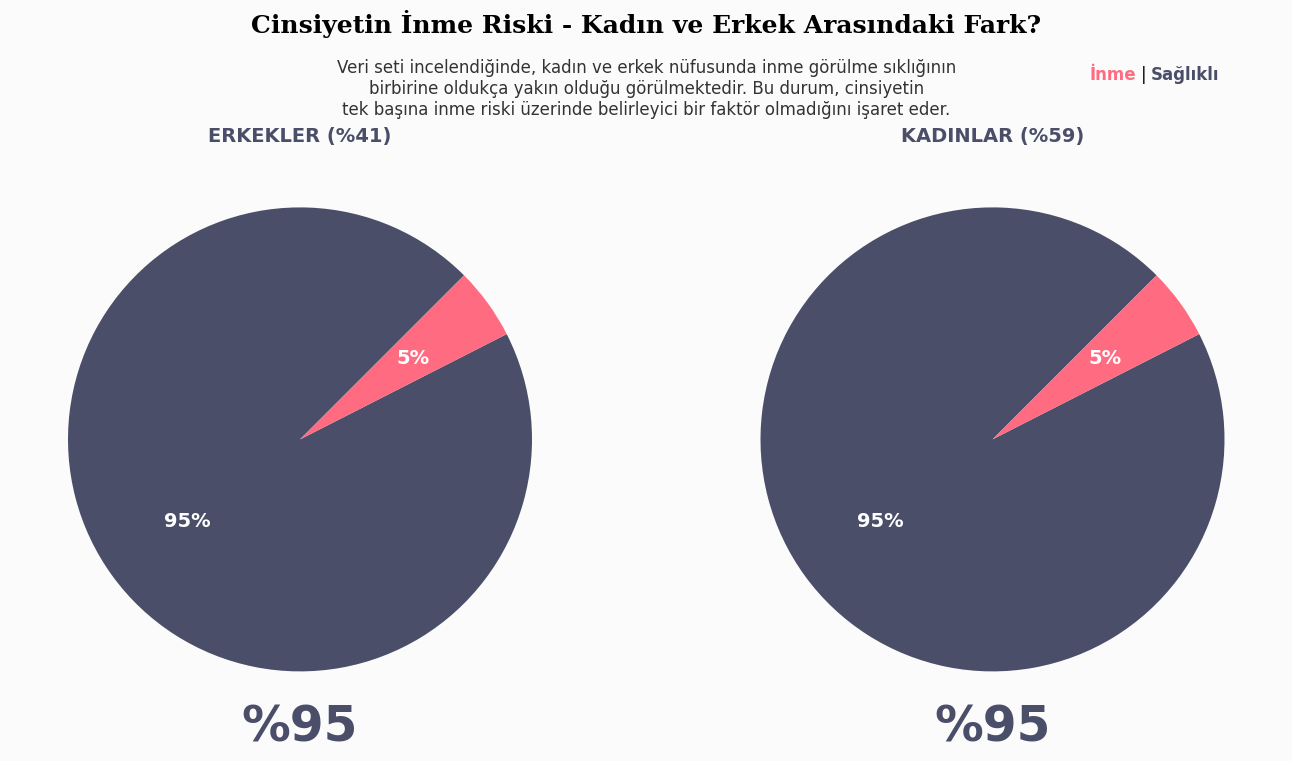

In [8]:
stroke_gender = df[df['stroke'] == 1]['gender'].value_counts().sort_index()
healthy_gender = df[df['stroke'] == 0]['gender'].value_counts().sort_index()

male_total = df['gender'].value_counts().sort_index().values[1]
female_total = df['gender'].value_counts().sort_index().values[0]

stroke_male_pct = int(round(stroke_gender.values[1] / male_total * 100, 0))
healthy_male_pct = int(round(healthy_gender.values[1] / male_total * 100, 0))

stroke_female_pct = int(round(stroke_gender.values[0] / female_total * 100, 0))
healthy_female_pct = int(round(healthy_gender.values[0] / female_total * 100, 0))

total_pop = male_total + female_total
male_pop_pct = int(round(male_total / total_pop * 100, 0))
female_pop_pct = int(round(female_total / total_pop * 100, 0))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81']

plt.suptitle('Cinsiyetin İnme Riski - Kadın ve Erkek Arasındaki Fark?',
             fontsize=18, fontweight='bold', fontfamily='serif', color='black', y=1.05)

aciklama = (
    "Veri seti incelendiğinde, kadın ve erkek nüfusunda inme görülme sıklığının\n"
    "birbirine oldukça yakın olduğu görülmektedir. Bu durum, cinsiyetin\n"
    "tek başına inme riski üzerinde belirleyici bir faktör olmadığını işaret eder."
)

fig.text(0.5, 0.90, aciklama, ha='center', fontsize=12, color='#333')

fig.text(0.85, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.855, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.86, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')

axes[0].pie([healthy_male_pct, stroke_male_pct], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[0].set_title(f'ERKEKLER (%{male_pop_pct})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[0].text(0, -1.3, f'%{healthy_male_pct}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

axes[1].pie([healthy_female_pct, stroke_female_pct], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[1].set_title(f'KADINLAR (%{female_pop_pct})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[1].text(0, -1.3, f'%{healthy_female_pct}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

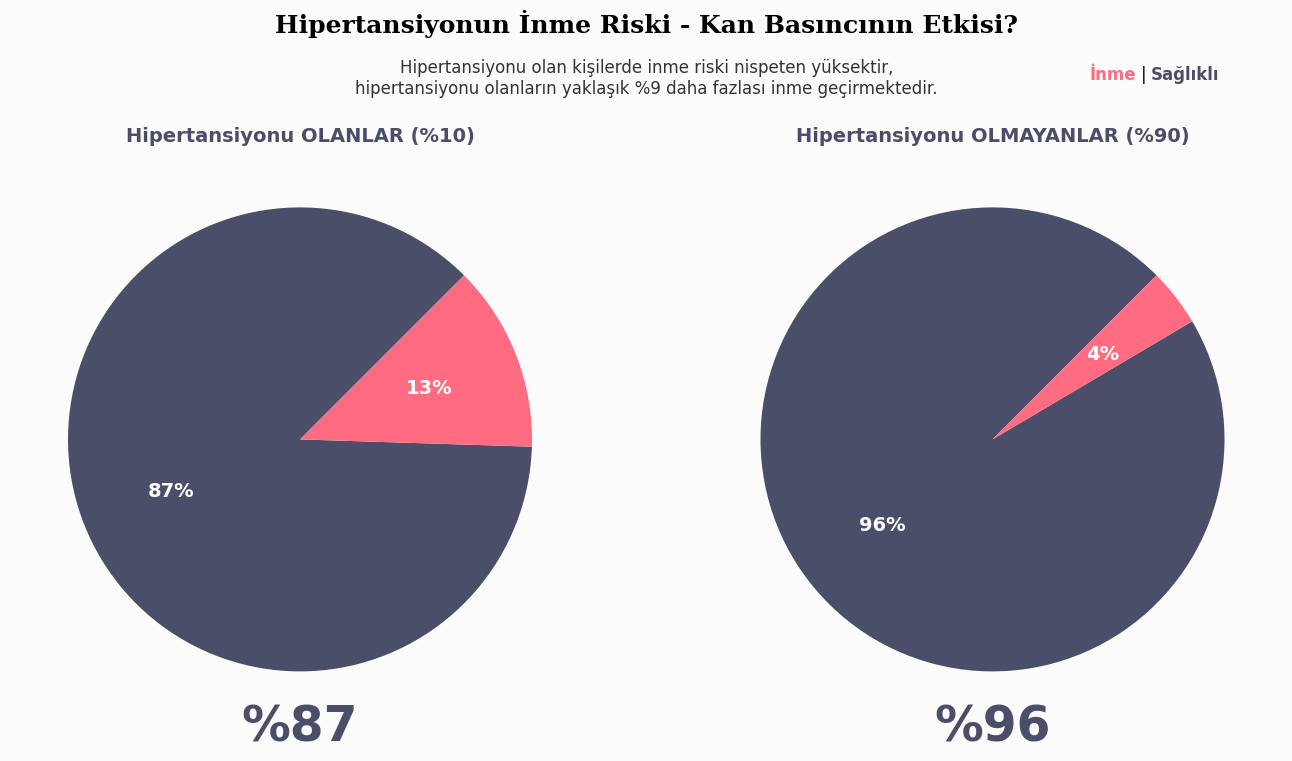

In [9]:
stroke_hyper = df[df['stroke'] == 1]['hypertension'].value_counts().sort_index()
healthy_hyper = df[df['stroke'] == 0]['hypertension'].value_counts().sort_index()

no = df['hypertension'].value_counts().sort_index().values[0]
yes = df['hypertension'].value_counts().sort_index().values[1]

stroke_no = int(round(stroke_hyper.values[0] / no * 100, 0))
stroke_yes = int(round(stroke_hyper.values[1] / yes * 100, 0))
healthy_no = int(round(healthy_hyper.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_hyper.values[1] / yes * 100, 0))

no_per = int(round(no / (no + yes) * 100, 0))
yes_per = int(round(yes / (no + yes) * 100, 0))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81']
plt.suptitle('Hipertansiyonun İnme Riski - Kan Basıncının Etkisi?',
             fontsize=18, fontweight='bold', fontfamily='serif', color='black', y=1.05)
fark = stroke_yes - stroke_no
aciklama = (f"Hipertansiyonu olan kişilerde inme riski nispeten yüksektir,\n"
            f"hipertansiyonu olanların yaklaşık %{fark} daha fazlası inme geçirmektedir.")

fig.text(0.5, 0.93, aciklama, ha='center', fontsize=12, color='#333')
fig.text(0.85, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.855, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.86, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')

axes[0].pie([healthy_yes, stroke_yes], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14}) # Sadece yüzdeler beyaz
axes[0].set_title(f'Hipertansiyonu OLANLAR (%{yes_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[0].text(0, -1.3, f'%{healthy_yes}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

axes[1].pie([healthy_no, stroke_no], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14}) # Sadece yüzdeler beyaz
axes[1].set_title(f'Hipertansiyonu OLMAYANLAR (%{no_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[1].text(0, -1.3, f'%{healthy_no}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

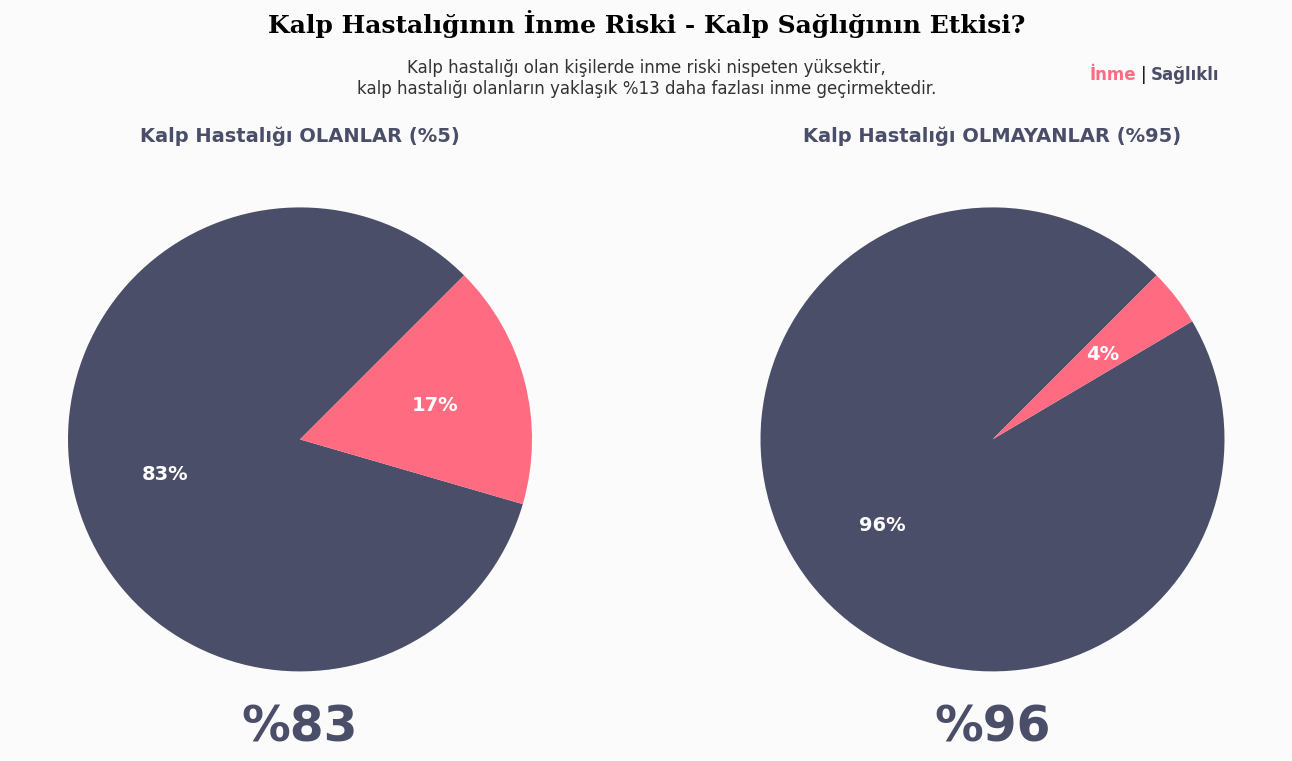

In [10]:
stroke_conf = df[df['stroke'] == 1]['heart_disease'].value_counts().sort_index()
healthy_conf = df[df['stroke'] == 0]['heart_disease'].value_counts().sort_index()

no = df['heart_disease'].value_counts().sort_index().values[0]
yes = df['heart_disease'].value_counts().sort_index().values[1]

stroke_no = int(round(stroke_conf.values[0] / no * 100, 0))
stroke_yes = int(round(stroke_conf.values[1] / yes * 100, 0))
healthy_no = int(round(healthy_conf.values[0] / no * 100, 0))
healthy_yes = int(round(healthy_conf.values[1] / yes * 100, 0))

no_per = int(round(no / (no + yes) * 100, 0))
yes_per = int(round(yes / (no + yes) * 100, 0))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81'] # Mor (Sağlıklı), Pembe (İnme)
plt.suptitle('Kalp Hastalığının İnme Riski - Kalp Sağlığının Etkisi?',
             fontsize=18, fontweight='bold', fontfamily='serif', color='black', y=1.05)
fark = stroke_yes - stroke_no
aciklama = (f"Kalp hastalığı olan kişilerde inme riski nispeten yüksektir,\n"
            f"kalp hastalığı olanların yaklaşık %{fark} daha fazlası inme geçirmektedir.")
fig.text(0.5, 0.93, aciklama, ha='center', fontsize=12, color='#333')
fig.text(0.85, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.855, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.86, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')

axes[0].pie([healthy_yes, stroke_yes], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[0].set_title(f'Kalp Hastalığı OLANLAR (%{yes_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[0].text(0, -1.3, f'%{healthy_yes}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

axes[1].pie([healthy_no, stroke_no], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[1].set_title(f'Kalp Hastalığı OLMAYANLAR (%{no_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[1].text(0, -1.3, f'%{healthy_no}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

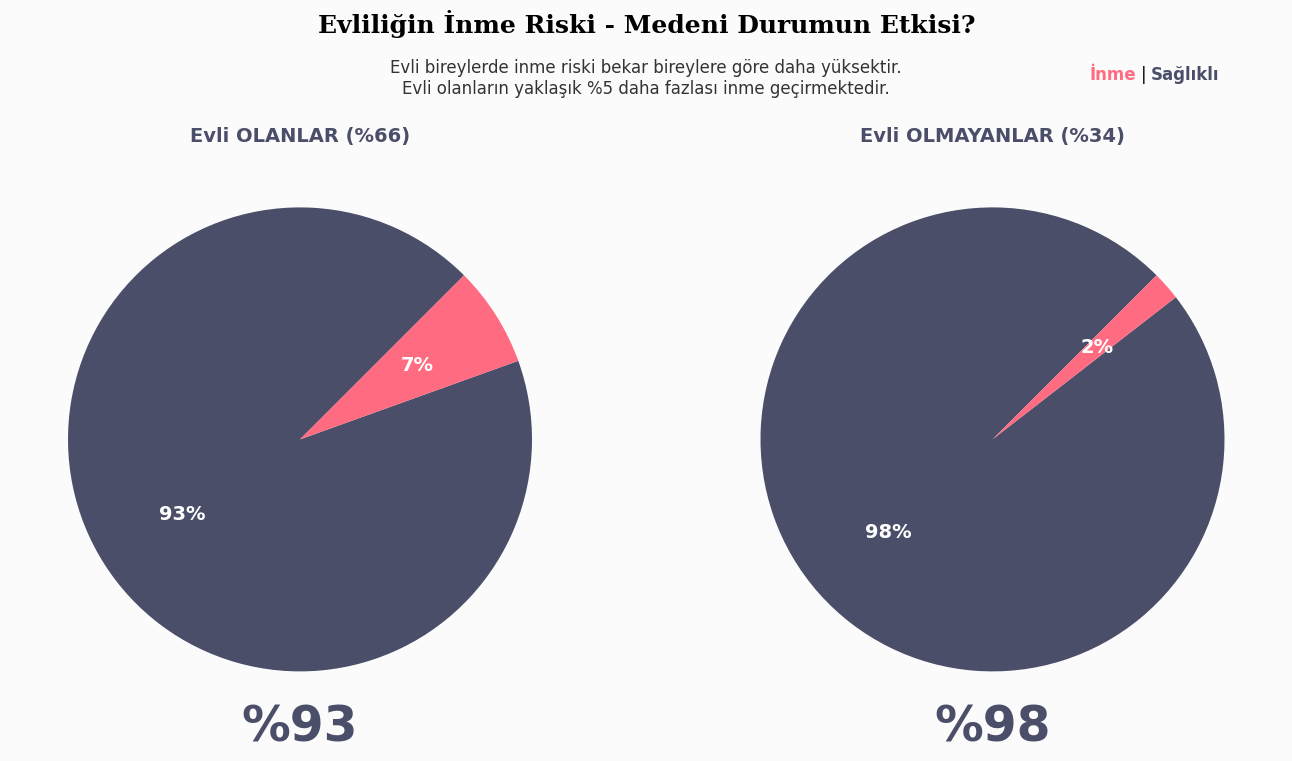

In [11]:
stroke_mary = df[df['stroke'] == 1]['ever_married'].value_counts()
healthy_mary = df[df['stroke'] == 0]['ever_married'].value_counts()

yes = df['ever_married'].value_counts().values[0]
no =  df['ever_married'].value_counts().values[1]

stroke_yes = int(round(stroke_mary.values[0] / yes * 100, 0))
healthy_yes = int(round(healthy_mary.values[0] / yes * 100, 0))
stroke_no = int(round(stroke_mary.values[1] / no * 100, 0))
healthy_no = int(round(healthy_mary.values[1] / no * 100, 0))

no_per = int(round(no / (no + yes) * 100, 0))
yes_per = int(round(yes / (no + yes) * 100, 0))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81']

plt.suptitle('Evliliğin İnme Riski - Medeni Durumun Etkisi?',
             fontsize=18, fontweight='bold', fontfamily='serif', color='black', y=1.05)


fark = abs(stroke_yes - stroke_no)
aciklama = (f"Evli bireylerde inme riski bekar bireylere göre daha yüksektir.\n"
            f"Evli olanların yaklaşık %{fark} daha fazlası inme geçirmektedir.")

fig.text(0.5, 0.93, aciklama, ha='center', fontsize=12, color='#333')
fig.text(0.85, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.855, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.86, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')


axes[0].pie([healthy_yes, stroke_yes], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[0].set_title(f'Evli OLANLAR (%{yes_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[0].text(0, -1.3, f'%{healthy_yes}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

axes[1].pie([healthy_no, stroke_no], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[1].set_title(f'Evli OLMAYANLAR (%{no_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[1].text(0, -1.3, f'%{healthy_no}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

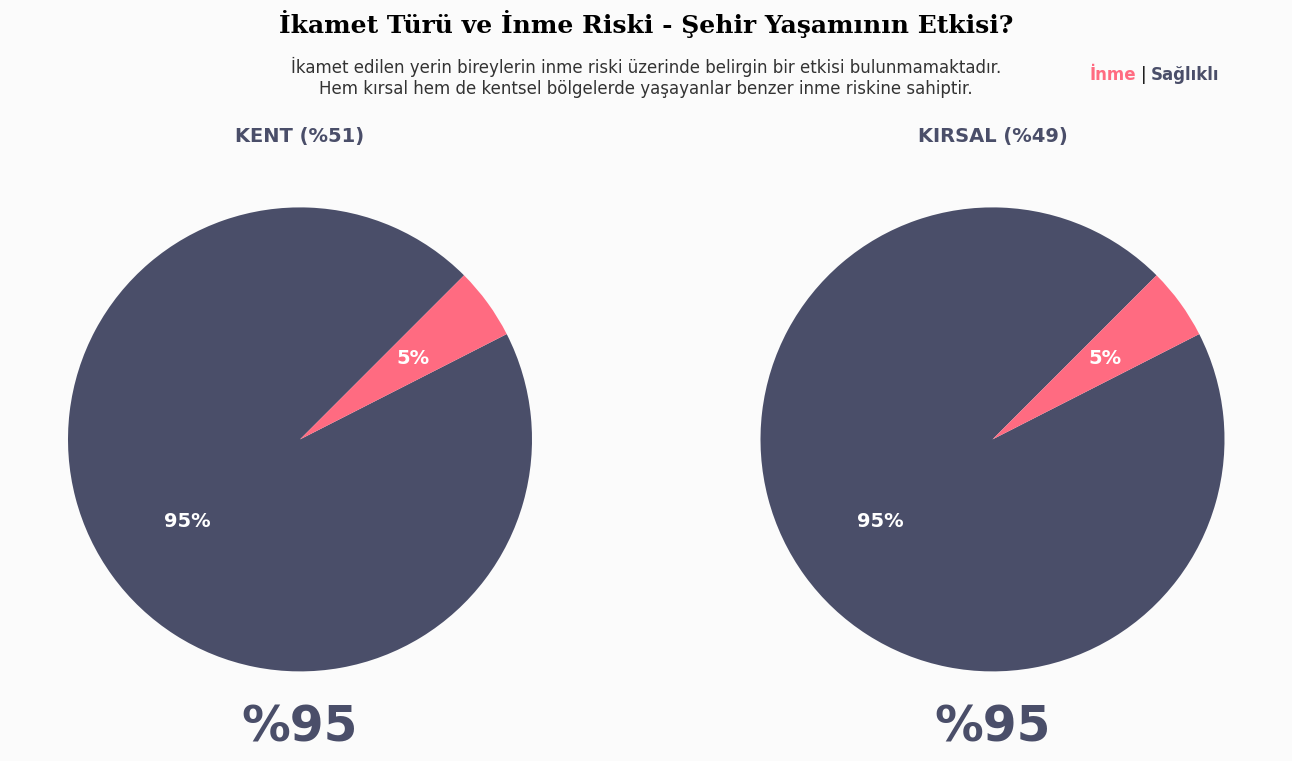

In [12]:
stroke_home = df[df['stroke'] == 1]['Residence_type'].value_counts()
healthy_home= df[df['stroke'] == 0]['Residence_type'].value_counts()

urban = df['Residence_type'].value_counts().values[0]
rural =  df['Residence_type'].value_counts().values[1]

stroke_urban = int(round (stroke_home.values[0] / urban * 100, 0))
stroke_rural = int(round( stroke_home.values[1] / rural *100, 0))
healthy_urban = int(round(healthy_home.values[0] / urban * 100, 0))
healthy_rural = int(round(healthy_home.values[1] / rural *100, 0))

urban_per = int(round(urban/(urban+rural) * 100, 0))
rural_per = int(round(rural/(urban+rural)* 100, 0))

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81']

plt.suptitle('İkamet Türü ve İnme Riski - Şehir Yaşamının Etkisi?',
             fontsize=18, fontweight='bold', fontfamily='serif', color='black', y=1.05)

aciklama = (
    "İkamet edilen yerin bireylerin inme riski üzerinde belirgin bir etkisi bulunmamaktadır.\n"
    "Hem kırsal hem de kentsel bölgelerde yaşayanlar benzer inme riskine sahiptir."
)

fig.text(0.5, 0.93, aciklama, ha='center', fontsize=12, color='#333')
fig.text(0.85, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.855, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.86, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')

axes[0].pie([healthy_urban, stroke_urban], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[0].set_title(f'KENT (%{urban_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[0].text(0, -1.3, f'%{healthy_urban}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')
axes[1].pie([healthy_rural, stroke_rural], labels=None, autopct='%1.0f%%',
            colors=colors, startangle=45,
            textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
axes[1].set_title(f'KIRSAL (%{rural_per})', fontsize=14, fontweight='bold', color='#4a4e69')
axes[1].text(0, -1.3, f'%{healthy_rural}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()

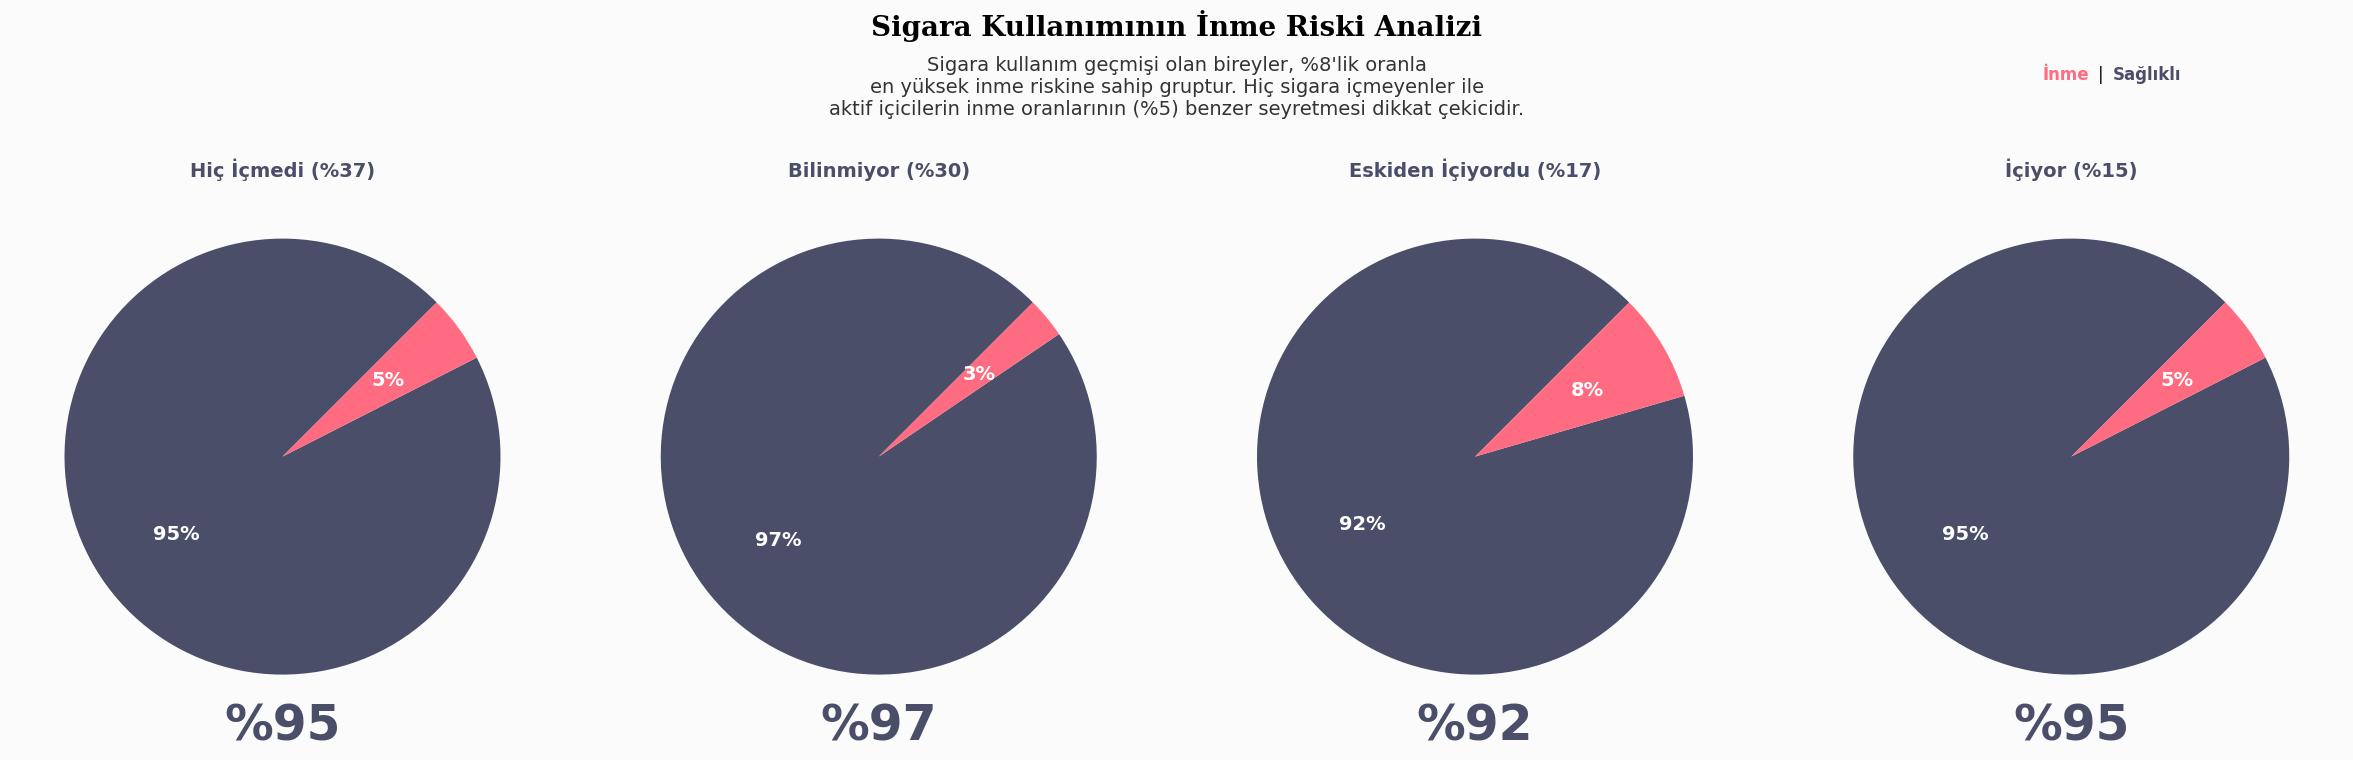

In [13]:
smoke = df['smoking_status'].value_counts()
stroke_smoke = df[df['stroke'] == 1]['smoking_status'].value_counts()
healthy_smoke = df[df['stroke'] == 0]['smoking_status'].value_counts()

never = smoke.values[0]
unknown =  smoke.values[1]
former = smoke.values[2]
smokes = smoke.values[3]

stroke_never = int(round (stroke_smoke.values[0] / never * 100, 0))
stroke_unknown = int(round( stroke_smoke.values[2]  / unknown *100, 0))
stroke_former = int(round (stroke_smoke.values[1]  / former * 100, 0))
stroke_smokes = int(round( stroke_smoke.values[3]  / smokes *100, 0))

healthy_never = int(round(healthy_smoke.values[0] / never * 100, 0))
healthy_unknown = int(round(healthy_smoke.values[1] / unknown *100, 0))
healthy_former = int(round(healthy_smoke.values[2] / former * 100, 0))
healthy_smokes = int(round(healthy_smoke.values[3]/ smokes *100, 0))

never_per = int(round(never/(never+unknown+former+smokes) * 100, 0))
unknown_per = int(round(unknown/(never+unknown+former+smokes)* 100, 0))
former_per = int(round(former/(never+unknown+former+smokes) * 100, 0))
smokes_per = int(round(smokes/(never+unknown+former+smokes)* 100, 0))

fig, axes = plt.subplots(1, 4, figsize=(24, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81']

plt.suptitle('Sigara Kullanımının İnme Riski Analizi',
             fontsize=20, fontweight='bold', fontfamily='serif', color='black', y=1.05)

aciklama = (
    "Sigara kullanım geçmişi olan bireyler, %8'lik oranla\n"
    "en yüksek inme riskine sahip gruptur. Hiç sigara içmeyenler ile\n"
    "aktif içicilerin inme oranlarının (%5) benzer seyretmesi dikkat çekicidir."
)
fig.text(0.5, 0.90, aciklama, ha='center', fontsize=14, color='#333')

fig.text(0.88, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.885, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.89, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')

plot_data = [
    ("Hiç İçmedi", never_per, healthy_never, stroke_never),
    ("Bilinmiyor", unknown_per, healthy_unknown, stroke_unknown),
    ("Eskiden İçiyordu", former_per, healthy_former, stroke_former),
    ("İçiyor", smokes_per, healthy_smokes, stroke_smokes)
]

for i, (label, pop_per, h_val, s_val) in enumerate(plot_data):
    axes[i].pie([h_val, s_val], labels=None, autopct='%1.0f%%',
                colors=colors, startangle=45,
                textprops={'color': 'white', 'weight': 'bold', 'fontsize': 14})
    axes[i].set_title(f'{label} (%{pop_per})', fontsize=14, fontweight='bold', color='#4a4e69')
    axes[i].text(0, -1.3, f'%{h_val}', ha='center', fontsize=35, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.80)
plt.show()

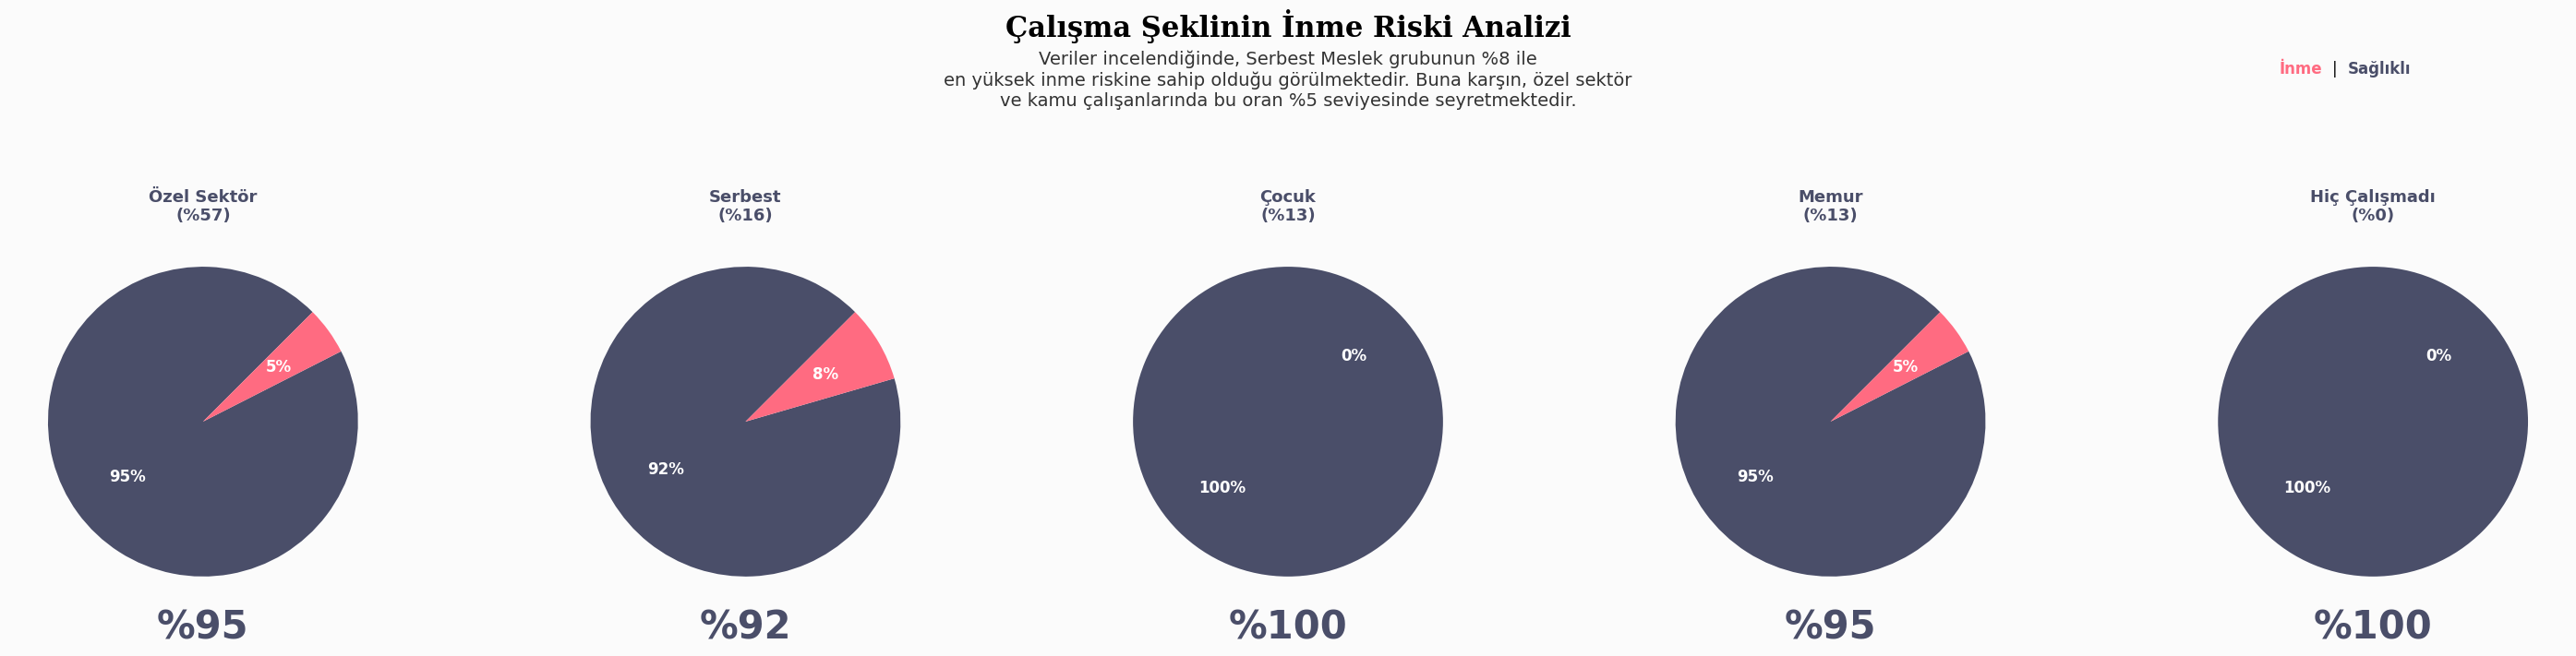

In [14]:
work = df['work_type'].value_counts()
stroke_work = df[df['stroke'] == 1]['work_type'].value_counts()
healthy_work = df[df['stroke'] == 0]['work_type'].value_counts()

private = work.values[0]
self =  work.values[1]
child = work.values[2]
gov = work.values[3]
never = work.values[4]

stroke_private = int(round (stroke_work.values[0] / private * 100, 0))
stroke_self = int(round( stroke_work.values[1]  / self *100, 0))
stroke_child = int(round (stroke_work.values[3]  / child * 100, 0))
stroke_gov = int(round( stroke_work.values[2]  / gov *100, 0))
stroke_never = int(round( 0, 0))

healthy_private = int(round(healthy_work.values[0] / private * 100, 0))
healthy_self = int(round(healthy_work.values[1] / self *100, 0))
healthy_child = int(round(healthy_work.values[2] / child * 100, 0))
healthy_gov = int(round(healthy_work.values[3]/ gov *100, 0))
healthy_never = int(round(healthy_work.values[4]/ never *100, 0))


total_pop = private + self + child + gov + never
private_per = int(round(private / total_pop * 100, 0))
self_per = int(round(self / total_pop * 100, 0))
child_per = int(round(child / total_pop * 100, 0))
gov_per = int(round(gov / total_pop * 100, 0))
never_per = int(round(never / total_pop * 100, 0))

fig, axes = plt.subplots(1, 5, figsize=(28, 7))
fig.patch.set_facecolor('#fbfbfb')
colors = ['#4a4e69', '#ff6b81']

plt.suptitle('Çalışma Şeklinin İnme Riski Analizi',
             fontsize=22, fontweight='bold', fontfamily='serif', color='black', y=1.05)

aciklama = (
    "Veriler incelendiğinde, Serbest Meslek grubunun %8 ile\n"
    "en yüksek inme riskine sahip olduğu görülmektedir. Buna karşın, özel sektör\n"
    "ve kamu çalışanlarında bu oran %5 seviyesinde seyretmektedir."
)
fig.text(0.5, 0.90, aciklama, ha='center', fontsize=14, color='#333')
fig.text(0.90, 0.95, 'İnme', color='#ff6b81', fontweight='bold', fontsize=12, ha='right')
fig.text(0.905, 0.95, '|', color='black', fontsize=12, ha='center')
fig.text(0.91, 0.95, 'Sağlıklı', color='#4a4e69', fontweight='bold', fontsize=12, ha='left')

plot_data = [
    ("Özel Sektör", private_per, healthy_private, stroke_private),
    ("Serbest", self_per, healthy_self, stroke_self),
    ("Çocuk", child_per, healthy_child, stroke_child),
    ("Memur", gov_per, healthy_gov, stroke_gov),
    ("Hiç Çalışmadı", never_per, healthy_never, stroke_never)
]

for i, (label, pop_per, h_val, s_val) in enumerate(plot_data):
    axes[i].pie([h_val, s_val], labels=None, autopct='%1.0f%%',
                colors=colors, startangle=45,
                textprops={'color': 'white', 'weight': 'bold', 'fontsize': 12})
    axes[i].set_title(f'{label}\n(%{pop_per})', fontsize=13, fontweight='bold', color='#4a4e69')
    axes[i].text(0, -1.4, f'%{h_val}', ha='center', fontsize=30, fontweight='bold', color='#4a4e69')

plt.tight_layout()
plt.subplots_adjust(top=0.80, wspace=0.4)
plt.show()

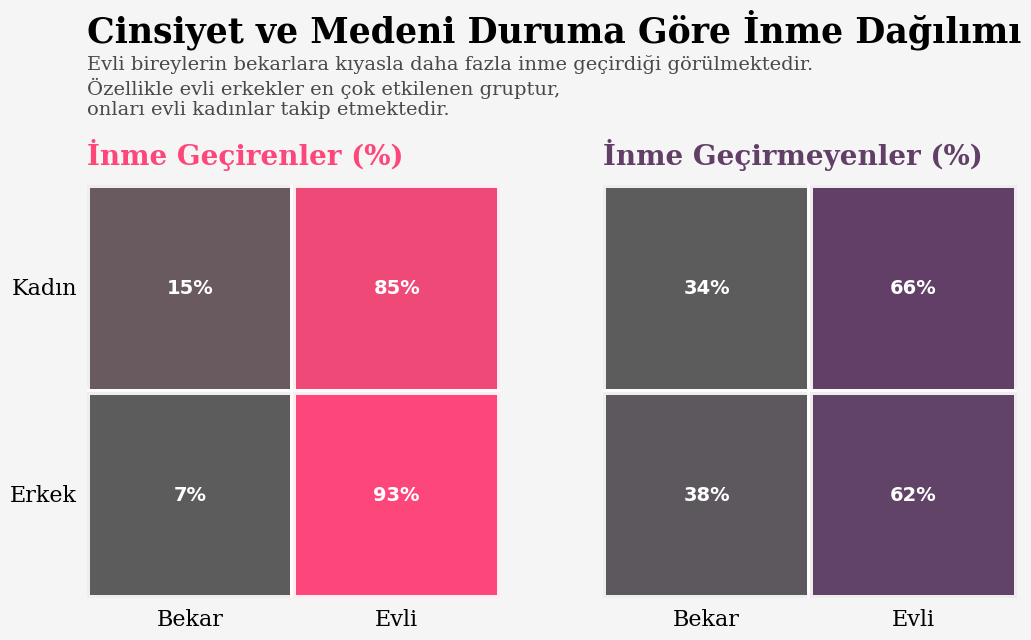

In [15]:
healthy = df[df['stroke'] == 0]
stroke_df = df[df['stroke'] == 1]

col1 = ["#4b4b4c", "#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N=256)
col2 = ["#4b4b4c", "#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

stroke_cross = pd.crosstab(stroke_df['gender'], stroke_df['ever_married'], normalize='index')
no_stroke_cross = pd.crosstab(healthy['gender'], healthy['ever_married'], normalize='index')

fig = plt.figure(figsize=(12, 6), dpi=100)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

fig.patch.set_facecolor('#f6f5f5')
ax0.set_facecolor('#f6f5f5')
ax1.set_facecolor('#f6f5f5')

sns.heatmap(ax=ax0, data=stroke_cross, linewidths=0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,
            linewidth=3, cmap=colormap1, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 14, "fontweight": "bold"}, alpha=0.9)

sns.heatmap(ax=ax1, data=no_stroke_cross, linewidths=0,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,
            linewidth=3, cmap=colormap2, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 14, "fontweight": "bold"}, alpha=0.9)

ax0.text(0, -0.69, 'Cinsiyet ve Medeni Duruma Göre İnme Dağılımı',
         {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 25})

aciklama = (
    "Evli bireylerin bekarlara kıyasla daha fazla inme geçirdiği görülmektedir.\n"
    "Özellikle evli erkekler en çok etkilenen gruptur, onları evli kadınlar takip etmektedir."
)
ax0.text(0, -0.34, aciklama, {'font': 'Serif', 'color': 'black', 'size': 14}, alpha=0.7)
ax0.text(0, -0.1, 'İnme Geçirenler (%)', {'font': 'serif', 'color': "#fe346e", 'size': 20, "weight":"bold"}, alpha=0.9)
ax1.text(0, -0.1, 'İnme Geçirmeyenler (%)', {'font': 'serif', 'color': "#512b58", 'size': 20, "weight":"bold"}, alpha=0.9)
ax0.axes.set_xticklabels(['Bekar', 'Evli'], fontfamily='serif', color='black', fontsize=16)
ax1.axes.set_xticklabels(['Bekar', 'Evli'], fontfamily='serif', color='black', fontsize=16)
ax0.axes.set_yticklabels(['Kadın', 'Erkek'], fontfamily='serif', color='black', fontsize=16, rotation=0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax1.tick_params(left=False, bottom=False)

fig.show()

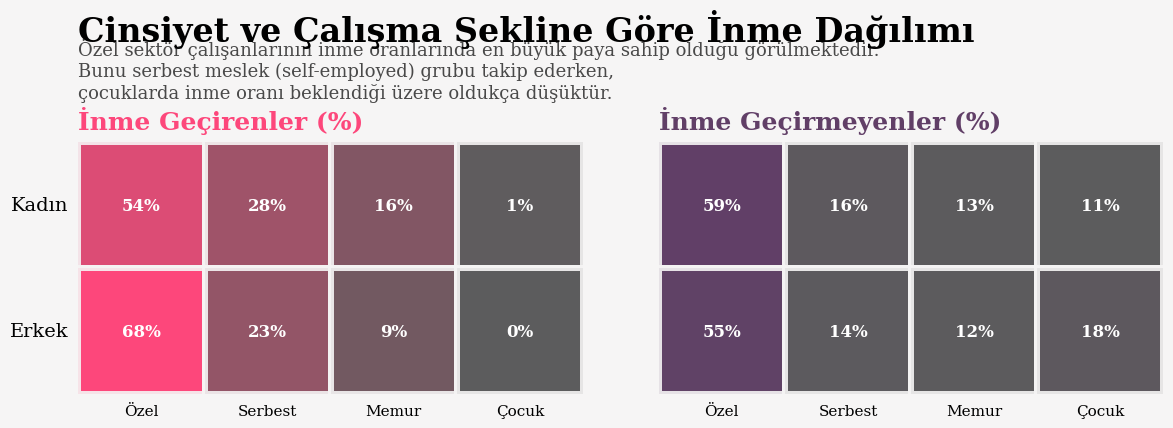

In [16]:
healthy = df[df['stroke'] == 0]
stroke_df = df[df['stroke'] == 1]

gender_order = ['Female', 'Male']
work_order = ['Private', 'Self-employed', 'Govt_job', 'children']

col1 = ["#4b4b4c", "#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N=256)

col2 = ["#4b4b4c", "#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

stroke_cross = pd.crosstab(stroke_df['gender'], [stroke_df['work_type']], normalize='index').loc[gender_order, work_order]
no_stroke_cross = pd.crosstab(healthy['gender'], [healthy['work_type']], normalize='index').loc[gender_order, work_order]

fig = plt.figure(figsize=(14, 6), dpi=100)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.15, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

background_color = "#f6f5f5"
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

sns.heatmap(ax=ax0, data=stroke_cross,
            square=True, cbar=False,
            linewidths=3, linecolor=background_color,
            cmap=colormap1, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 12, "fontweight": "bold", "fontfamily": "serif"}, alpha=0.9)

sns.heatmap(ax=ax1, data=no_stroke_cross,
            square=True, cbar=False,
            linewidths=3, linecolor=background_color,
            cmap=colormap2, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 12, "fontweight": "bold", "fontfamily": "serif"}, alpha=0.9)

ax0.text(0, -0.8, 'Cinsiyet ve Çalışma Şekline Göre İnme Dağılımı',
         {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 24})

aciklama = (
    "Özel sektör çalışanlarının inme oranlarında en büyük paya sahip olduğu görülmektedir.\n"
    "Bunu serbest meslek (self-employed) grubu takip ederken,\n"
    "çocuklarda inme oranı beklendiği üzere oldukça düşüktür."
)
ax0.text(0, -0.35, aciklama, {'font': 'Serif', 'color': 'black', 'size': 13}, alpha=0.7)
ax0.text(0, -0.1, 'İnme Geçirenler (%)', {'font': 'serif', 'color': "#fe346e", 'size': 18, "weight":"bold"}, alpha=0.9)
ax1.text(0, -0.1, 'İnme Geçirmeyenler (%)', {'font': 'serif', 'color': "#512b58", 'size': 18, "weight":"bold"}, alpha=0.9)

tr_labels = ['Özel', 'Serbest', 'Memur', 'Çocuk']
ax0.set_xticklabels(tr_labels, fontfamily='serif', color='black', fontsize=11)
ax1.set_xticklabels(tr_labels, fontfamily='serif', color='black', fontsize=11)


ax0.set_yticklabels(['Kadın', 'Erkek'], fontfamily='serif', color='black', fontsize=14, rotation=0)


ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)

ax0.tick_params(left=False, bottom=False)
ax1.tick_params(left=False, bottom=False)

plt.show()

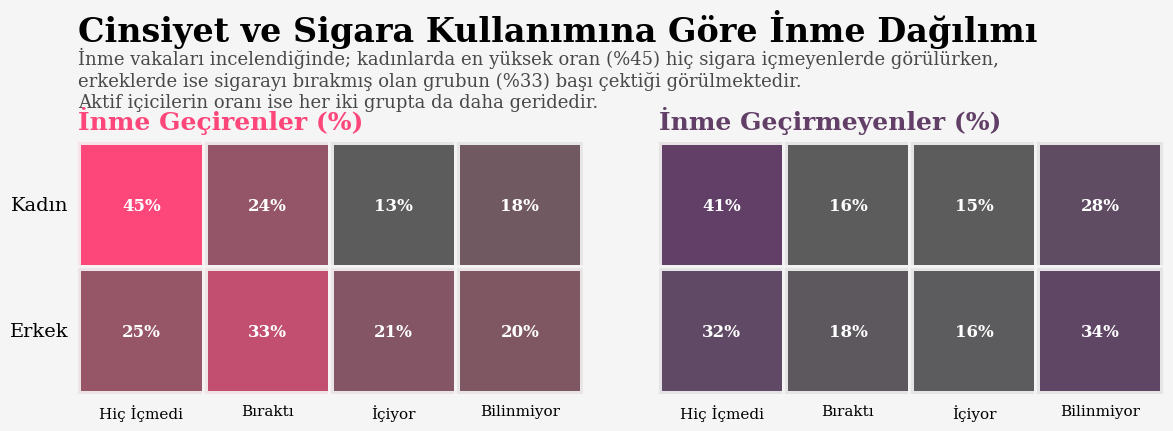

In [17]:
healthy = df[df['stroke'] == 0]
stroke_df = df[df['stroke'] == 1]

gender_order = ['Female', 'Male']
smoking_order = ['never smoked', 'formerly smoked', 'smokes', 'Unknown']

col1 = ["#4b4b4c", "#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N=256)

col2 = ["#4b4b4c", "#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

stroke_cross = pd.crosstab(stroke_df['gender'], [stroke_df['smoking_status']], normalize='index').loc[gender_order, smoking_order]
no_stroke_cross = pd.crosstab(healthy['gender'], [healthy['smoking_status']], normalize='index').loc[gender_order, smoking_order]

fig = plt.figure(figsize=(14, 6), dpi=100)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.15, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

background_color = "#f6f5f5"
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

sns.heatmap(ax=ax0, data=stroke_cross,
            square=True, cbar=False,
            linewidths=3, linecolor=background_color,
            cmap=colormap1, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 12, "fontweight": "bold", "fontfamily": "serif"}, alpha=0.9)

sns.heatmap(ax=ax1, data=no_stroke_cross,
            square=True, cbar=False,
            linewidths=3, linecolor=background_color,
            cmap=colormap2, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 12, "fontweight": "bold", "fontfamily": "serif"}, alpha=0.9)
ax0.text(0, -0.8, 'Cinsiyet ve Sigara Kullanımına Göre İnme Dağılımı',
         {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 24})


aciklama = (
    "İnme vakaları incelendiğinde; kadınlarda en yüksek oran (%45) hiç sigara içmeyenlerde görülürken,\n"
    "erkeklerde ise sigarayı bırakmış olan grubun (%33) başı çektiği görülmektedir.\n"
    "Aktif içicilerin oranı ise her iki grupta da daha geridedir."
)
ax0.text(0, -0.28, aciklama, {'font': 'Serif', 'color': 'black', 'size': 13}, alpha=0.7)

ax0.text(0, -0.1, 'İnme Geçirenler (%)', {'font': 'serif', 'color': "#fe346e", 'size': 18, "weight":"bold"}, alpha=0.9)
ax1.text(0, -0.1, 'İnme Geçirmeyenler (%)', {'font': 'serif', 'color': "#512b58", 'size': 18, "weight":"bold"}, alpha=0.9)

tr_labels = ['Hiç İçmedi', 'Bıraktı', 'İçiyor', 'Bilinmiyor']
ax0.set_xticklabels(tr_labels, fontfamily='serif', color='black', fontsize=11)
ax1.set_xticklabels(tr_labels, fontfamily='serif', color='black', fontsize=11)

ax0.set_yticklabels(['Kadın', 'Erkek'], fontfamily='serif', color='black', fontsize=14, rotation=0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)

ax0.tick_params(left=False, bottom=False)
ax1.tick_params(left=False, bottom=False)

plt.show()

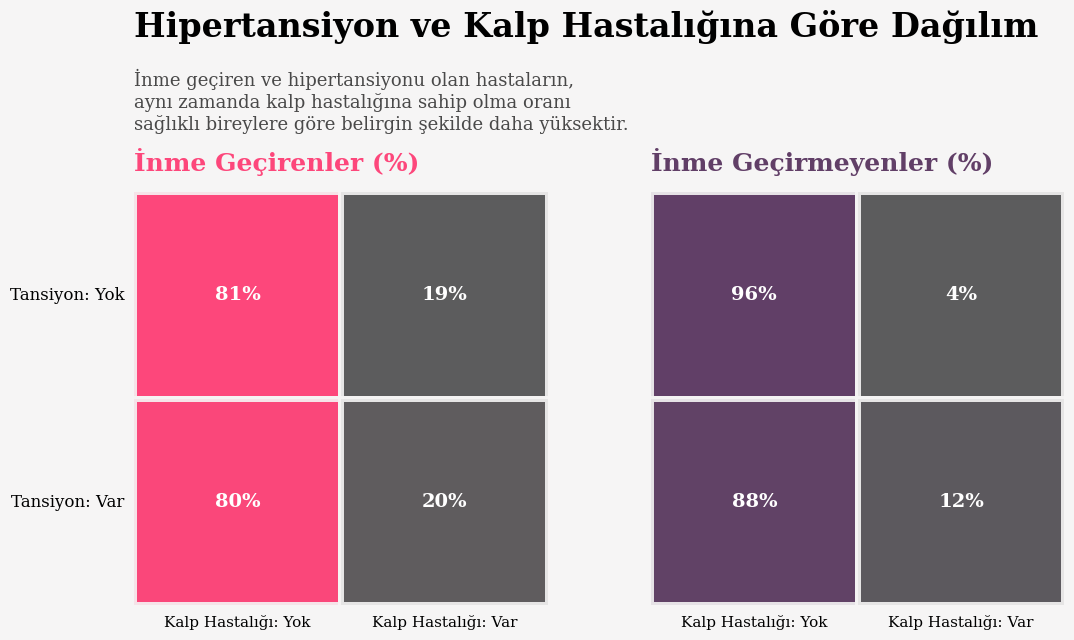

In [18]:
healthy = df[df['stroke'] == 0]
stroke_df = df[df['stroke'] == 1]

hyper_order = [0, 1]
heart_order = [0, 1]

col1 = ["#4b4b4c", "#fe346e"]
colormap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", col1, N=256)

col2 = ["#4b4b4c", "#512b58"]
colormap2 = matplotlib.colors.LinearSegmentedColormap.from_list("", col2)

stroke_cross = pd.crosstab(stroke_df['hypertension'], [stroke_df['heart_disease']], normalize='index')
no_stroke_cross = pd.crosstab(healthy['hypertension'], [healthy['heart_disease']], normalize='index')

fig = plt.figure(figsize=(12, 6), dpi=100)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.25, hspace=0.5)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])

background_color = "#f6f5f5"
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)

sns.heatmap(ax=ax0, data=stroke_cross,
            square=True, cbar=False,
            linewidths=3, linecolor=background_color,
            cmap=colormap1, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 14, "fontweight": "bold", "fontfamily": "serif"}, alpha=0.9)
sns.heatmap(ax=ax1, data=no_stroke_cross,
            square=True, cbar=False,
            linewidths=3, linecolor=background_color,
            cmap=colormap2, annot=True, fmt='1.0%',
            annot_kws={"fontsize": 14, "fontweight": "bold", "fontfamily": "serif"}, alpha=0.9)

ax0.text(0, -0.75, 'Hipertansiyon ve Kalp Hastalığına Göre Dağılım',
         {'font': 'Serif', 'color': 'black', 'weight': 'bold', 'size': 24})

aciklama = (
    "İnme geçiren ve hipertansiyonu olan hastaların,\n"
    "aynı zamanda kalp hastalığına sahip olma oranı\n"
    "sağlıklı bireylere göre belirgin şekilde daha yüksektir."
)
ax0.text(0, -0.30, aciklama, {'font': 'Serif', 'color': 'black', 'size': 13}, alpha=0.7)
ax0.text(0, -0.1, 'İnme Geçirenler (%)', {'font': 'serif', 'color': "#fe346e", 'size': 18, "weight":"bold"}, alpha=0.9)
ax1.text(0, -0.1, 'İnme Geçirmeyenler (%)', {'font': 'serif', 'color': "#512b58", 'size': 18, "weight":"bold"}, alpha=0.9)

labels_x = ['Kalp Hastalığı: Yok', 'Kalp Hastalığı: Var']
ax0.set_xticklabels(labels_x, fontfamily='serif', color='black', fontsize=11)
ax1.set_xticklabels(labels_x, fontfamily='serif', color='black', fontsize=11)

labels_y = ['Tansiyon: Yok', 'Tansiyon: Var']
ax0.set_yticklabels(labels_y, fontfamily='serif', color='black', fontsize=12, rotation=0)

ax0.set_xlabel('')
ax0.set_ylabel('')
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.axes.get_yaxis().set_visible(False)

ax0.tick_params(left=False, bottom=False)
ax1.tick_params(left=False, bottom=False)

plt.show()

In [19]:
# Cinsiyet
df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})

# Çalışma Şekli
df['work_type'] = df['work_type'].map({
    'Private': 0,
    'Self-employed': 1,
    'Govt_job': 3,
    'children': 2,
    'Never_worked': 4})

# İkamet Türü
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1})

# Sigara Durumu
df['smoking_status'] = df['smoking_status'].map({
    'formerly smoked': 2,
    'never smoked': 0,
    'smokes': 3,
    'Unknown': 1})

# Medeni Durum
df['ever_married'] = df['ever_married'].map({'Yes': 0, 'No': 1})


print("\n📋 İlk 5 Satır:")
print(df.head())

print("\n🔍 Sütun Bilgileri:")
print(df.info())


📋 İlk 5 Satır:
   gender   age  hypertension  heart_disease  ever_married  work_type  \
0       1  67.0             0              1             0          0   
1       0  61.0             0              0             0          1   
2       1  80.0             0              1             0          0   
3       0  49.0             0              0             0          0   
4       0  79.0             1              0             0          1   

   Residence_type  avg_glucose_level   bmi  smoking_status  stroke  
0               0             228.69  36.6               2       1  
1               1             202.21   NaN               0       1  
2               1             105.92  32.5               0       1  
3               0             171.23  34.4               3       1  
4               1             174.12  24.0               0       1  

🔍 Sütun Bilgileri:
<class 'pandas.core.frame.DataFrame'>
Index: 5109 entries, 0 to 5109
Data columns (total 11 columns):
 #   Colu

In [20]:
# Eksik veri kontrolü
print("\n🔍 Eksik Veri Kontrolü:")
missing_data = df.isnull().sum()
print(missing_data[missing_data > 0] if missing_data.sum() > 0 else "Eksik veri bulunmamaktadır.")

# Eksik verileri ortalama ile doldurma (varsa)
if df.isnull().sum().sum() > 0:
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            df[col]=df[col].fillna(df[col].mean())
print("✅ Eksik veriler ortalama ile dolduruldu.")


🔍 Eksik Veri Kontrolü:
bmi    201
dtype: int64
✅ Eksik veriler ortalama ile dolduruldu.


In [21]:
df.isnull().sum()

,0
gender,0
age,0
hypertension,0
heart_disease,0
ever_married,0
work_type,0
Residence_type,0
avg_glucose_level,0
bmi,0
smoking_status,0


In [22]:
# Sadece sürekli değişkenleri seçiyoruz (Kategoriklere dokunmuyoruz)
continuous_cols = ['age', 'avg_glucose_level', 'bmi']
print("\n🔧 Aykırı Değer Temizliği:")
outliers_count = 0
for col in continuous_cols:

    if col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()

        if outliers > 0:
            print(f"  - {col}: {outliers} aykırı değer baskılandı (Sınırlar: {lower_bound:.1f} - {upper_bound:.1f})")
            outliers_count += outliers

            df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
            df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])

if outliers_count == 0:
    print("  - Hiçbir aykırı değer tespit edilmedi.")

else:
    print(f"✅ Toplam {outliers_count} değer sınırlandırıldı.")


🔧 Aykırı Değer Temizliği:
  - avg_glucose_level: 627 aykırı değer baskılandı (Sınırlar: 22.0 - 169.4)
  - bmi: 126 aykırı değer baskılandı (Sınırlar: 10.3 - 46.3)
✅ Toplam 753 değer sınırlandırıldı.


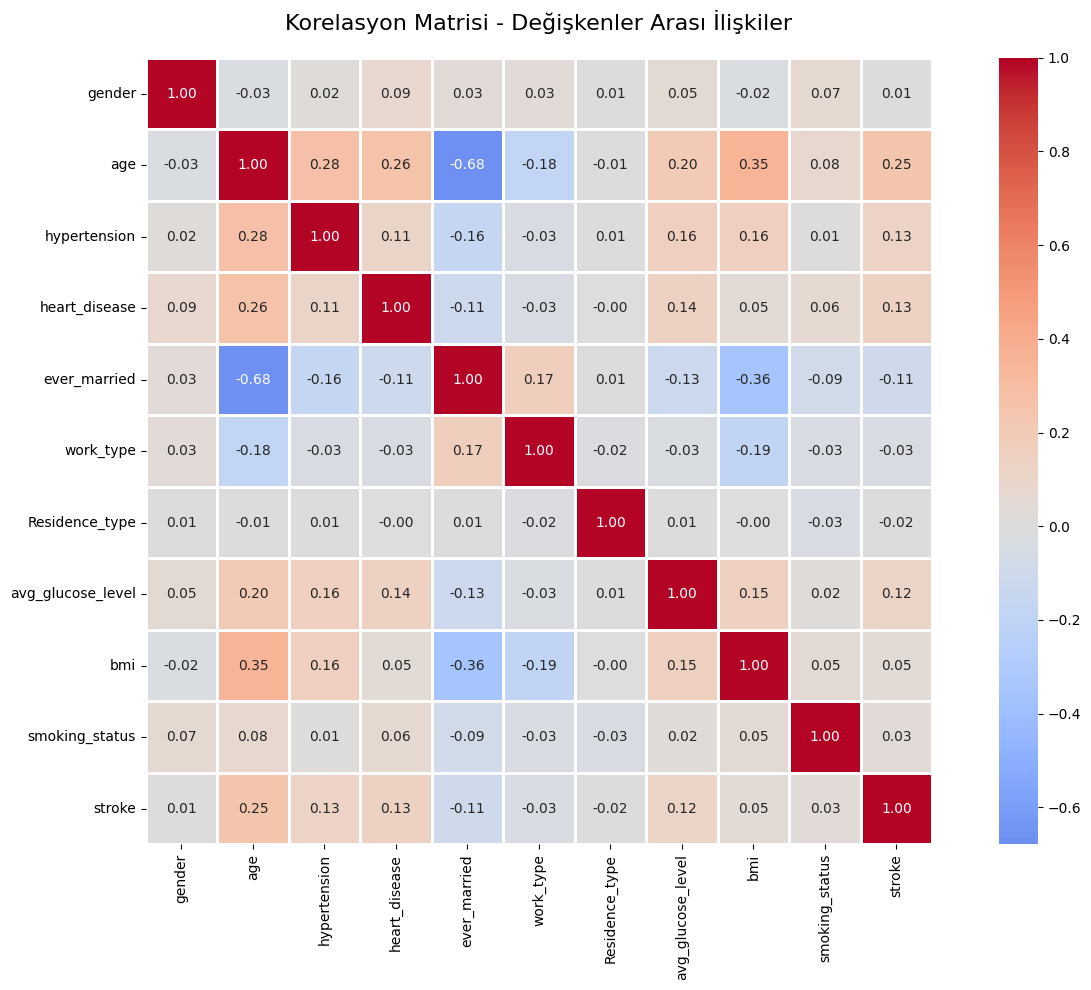

In [23]:
# Korelasyon Matrisi
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1)
plt.title('Korelasyon Matrisi - Değişkenler Arası İlişkiler', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

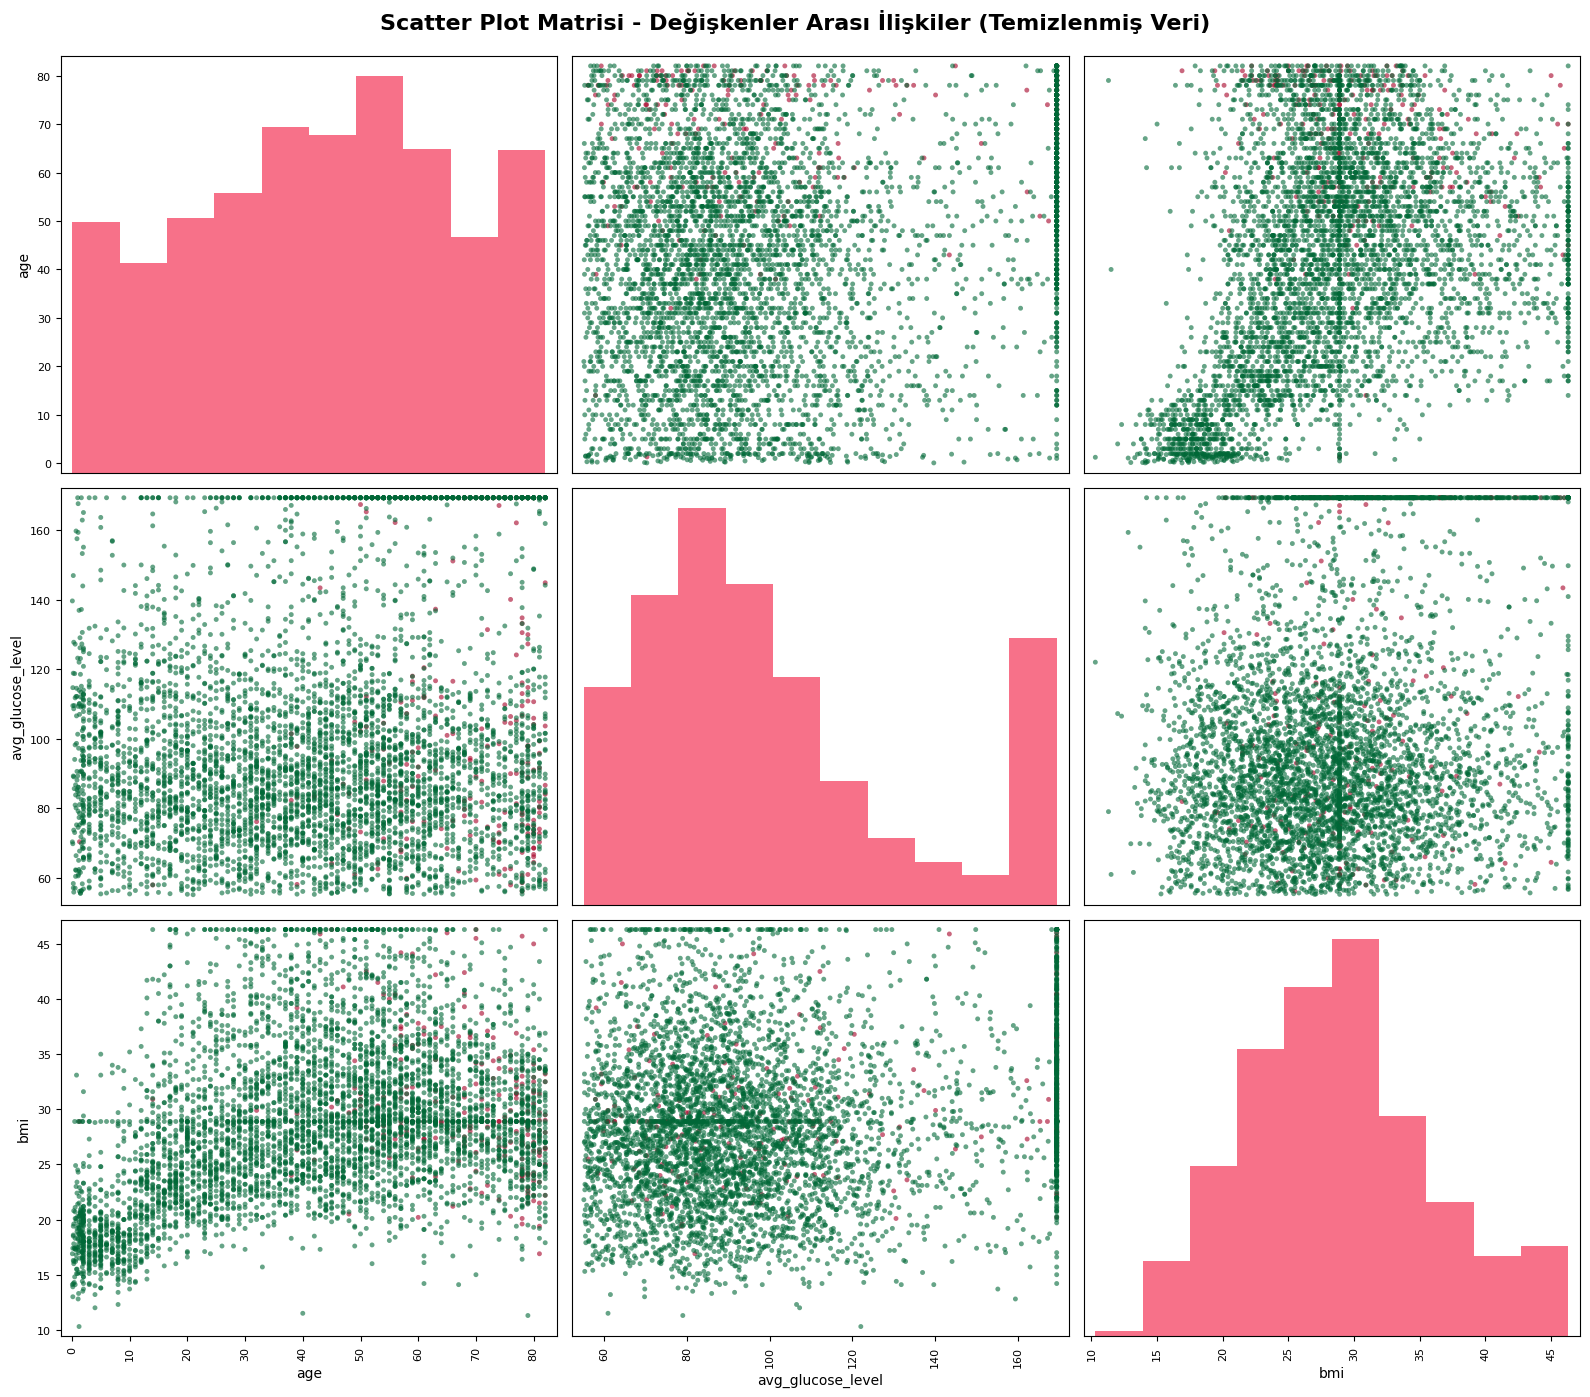

In [24]:
# Scatter Plot Matrisi (Sayısal Değişkenler)
pd.plotting.scatter_matrix(df[continuous_cols], figsize=(16, 14),
                           c=df['stroke'], cmap='RdYlGn_r',
                           alpha=0.6, diagonal='hist', s=50)
plt.suptitle('Scatter Plot Matrisi - Değişkenler Arası İlişkiler (Temizlenmiş Veri)',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [25]:
nominal_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
print(f"\n🔄 One-Hot Encoding uygulanıyor: {nominal_cols}")
df = pd.get_dummies(df, columns=nominal_cols, drop_first=False)
print(f"✅ Dönüşüm tamamlandı. Yeni sütun sayısı: {df.shape[1]}")
print("\n📋 Tüm Sütunların Listesi:")
print(df.columns.tolist())


🔄 One-Hot Encoding uygulanıyor: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
✅ Dönüşüm tamamlandı. Yeni sütun sayısı: 21

📋 Tüm Sütunların Listesi:
['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke', 'gender_0', 'gender_1', 'ever_married_0', 'ever_married_1', 'work_type_0', 'work_type_1', 'work_type_2', 'work_type_3', 'work_type_4', 'Residence_type_0', 'Residence_type_1', 'smoking_status_0', 'smoking_status_1', 'smoking_status_2', 'smoking_status_3']


In [26]:
# Özellik ve hedef değişkeni ayırma
X = df.drop('stroke', axis=1)
y = df['stroke']

# Eğitim ve test setine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=42,
                                                      stratify=y)

# scaler (train'e fit)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

print(f"\n📊 Veri Seti Bölünmesi:")
print(f"Eğitim seti boyutu: {X_train.shape[0]} ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"Test seti boyutu: {X_test.shape[0]} ({X_test.shape[0]/len(df)*100:.1f}%)")


📊 Veri Seti Bölünmesi:
Eğitim seti boyutu: 4087 (80.0%)
Test seti boyutu: 1022 (20.0%)


In [27]:
# Modeller ve hiperparametreler
models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'liblinear', 'saga']
        }
    },

    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 4],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.7, 0.8],
            'colsample_bytree': [0.8, 1.0],
            'reg_alpha': [0.1, 1],
            'reg_lambda': [1, 2],
            'gamma': [0.1, 0.2]
        }
    },

    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [6, 8, 10],
            'max_features': ['sqrt'],
            'min_samples_split': [5, 10],
            'min_samples_leaf': [2, 4, 6]
        }
    },

    'SVM': {
        'model': SVC(random_state=42, probability=True),
        'params': {
            'C': [1, 10],
            'kernel': ['rbf', 'linear'],
            'gamma': ['scale', 'auto']
        }
    }
}

In [29]:
# Çapraz doğrulama ayarları
cv_folds = 5

# Model eğitimi ve hiperparametre optimizasyonu
print(f"\n🔄 Çapraz Doğrulama: {cv_folds} kat")
print("\n🚀 Model Eğitimi Başlıyor...")

trained_models = {}
best_params = {}

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"📈 {name} Eğitiliyor...")

    model_pipeline = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('classifier', config['model'])
    ])

    new_params = {f'classifier__{key}': val for key, val in config['params'].items()}

    # GridSearchCV ile en iyi hiperparametreleri bulma
    grid_search = GridSearchCV(
        model_pipeline,
        new_params,
        cv=cv_folds,
        scoring='f1',
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train, y_train)
    trained_models[name] = grid_search.best_estimator_
    best_params[name] = grid_search.best_params_

    print(f"✅ En iyi parametreler: {grid_search.best_params_}")
    print(f"✅ En iyi CV skoru: {grid_search.best_score_:.4f}")

    # Çapraz doğrulama skorları
    cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,
                                cv=cv_folds, scoring='accuracy')
    print(f"✅ CV skorları: {cv_scores}")
    print(f"✅ Ortalama CV skoru: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

print("\n" + "="*60)
print("✅ Tüm modeller başarıyla eğitildi!")
print("\n" + "="*60)
print("🗳️ VOTING CLASSIFIER (ORTAK AKIL) OLUŞTURULUYOR...")

voting_estimators = [
    ('lr', trained_models['Logistic Regression']),
    ('xgb', trained_models['XGBoost']),
    ('rf', trained_models['Random Forest']),
    ('svm', trained_models['SVM'])
]

voting_clf = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_clf.fit(X_train, y_train)
trained_models['Voting Classifier'] = voting_clf
print("✅ Voting Classifier listeye eklendi.")


🔄 Çapraz Doğrulama: 5 kat

🚀 Model Eğitimi Başlıyor...

📈 Logistic Regression Eğitiliyor...
✅ En iyi parametreler: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
✅ En iyi CV skoru: 0.2312
✅ CV skorları: [0.700489   0.76528117 0.74051408 0.76132191 0.76744186]
✅ Ortalama CV skoru: 0.7470 (+/- 0.0503)

📈 XGBoost Eğitiliyor...
✅ En iyi parametreler: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__n_estimators': 100, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 1, 'classifier__subsample': 0.8}
✅ En iyi CV skoru: 0.2200
✅ CV skorları: [0.68826406 0.74572127 0.70257038 0.73072215 0.74418605]
✅ Ortalama CV skoru: 0.7223 (+/- 0.0460)

📈 Random Forest Eğitiliyor...
✅ En iyi parametreler: {'classifier__max_depth': 8, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 6, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
✅ En i

In [33]:
# Tahminler ve metrikler
results = {}
y_probs = {}

for name, model in trained_models.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'y_pred': y_pred
    }
    y_probs[name] = y_prob

    print(f"\n📊 {name} Sonuçları:")
    print(f"  Accuracy:  {results[name]['Accuracy']:.4f}")
    print(f"  Precision: {results[name]['Precision']:.4f}")
    print(f"  Recall:    {results[name]['Recall']:.4f}")
    print(f"  F1-Score:  {results[name]['F1-Score']:.4f}")


📊 Logistic Regression Sonuçları:
  Accuracy:  0.7387
  Precision: 0.1347
  Recall:    0.8000
  F1-Score:  0.2305

📊 XGBoost Sonuçları:
  Accuracy:  0.7231
  Precision: 0.1278
  Recall:    0.8000
  F1-Score:  0.2204

📊 Random Forest Sonuçları:
  Accuracy:  0.7652
  Precision: 0.1289
  Recall:    0.6600
  F1-Score:  0.2157

📊 SVM Sonuçları:
  Accuracy:  0.7094
  Precision: 0.1223
  Recall:    0.8000
  F1-Score:  0.2122

📊 Voting Classifier Sonuçları:
  Accuracy:  0.7387
  Precision: 0.1347
  Recall:    0.8000
  F1-Score:  0.2305


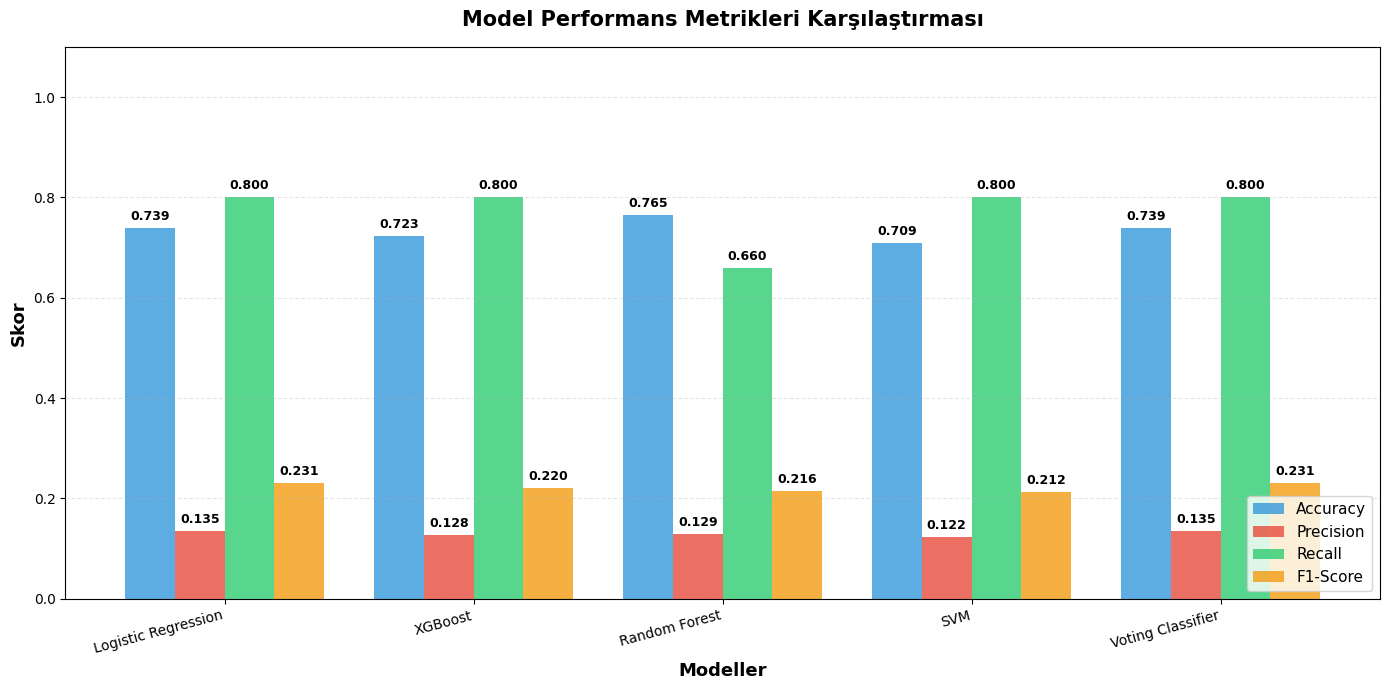

In [35]:
# Performans Metrikleri Karşılaştırma Grafiği
metrics_df = pd.DataFrame(results).T[['Accuracy', 'Precision', 'Recall', 'F1-Score']]

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(metrics_df.index))
width = 0.2

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
for i, metric in enumerate(metrics_df.columns):
    ax.bar(x + i * width, metrics_df[metric], width,
           label=metric, color=colors[i], alpha=0.8)

    # Değerleri gösterme
    for j, v in enumerate(metrics_df[metric]):
        ax.text(j + i * width, v + 0.01, f'{v:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Modeller', fontsize=13, fontweight='bold')
ax.set_ylabel('Skor', fontsize=13, fontweight='bold')
ax.set_title('Model Performans Metrikleri Karşılaştırması', fontsize=15, fontweight='bold', pad=15)
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(metrics_df.index, rotation=15, ha='right')
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

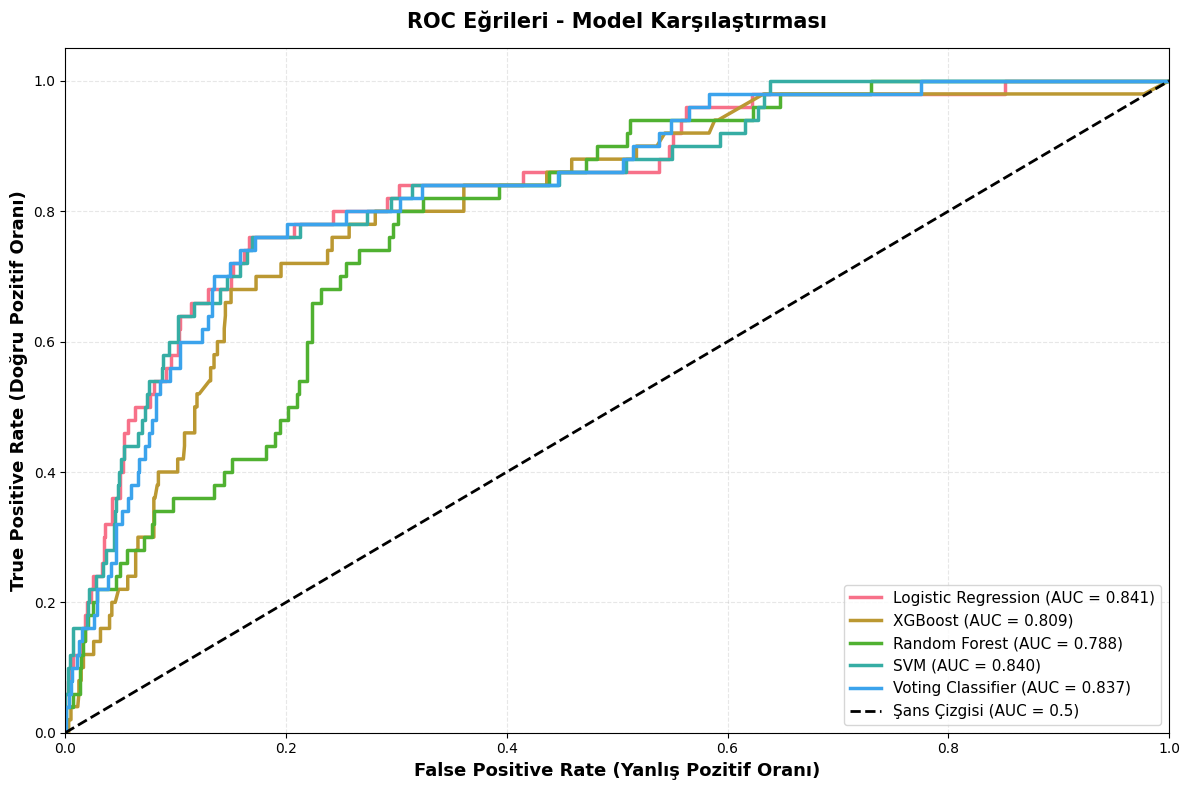

In [36]:
# ROC Eğrileri
plt.figure(figsize=(12, 8))

for name, y_prob in y_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, linewidth=2.5,
             label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Şans Çizgisi (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (Yanlış Pozitif Oranı)', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate (Doğru Pozitif Oranı)', fontsize=13, fontweight='bold')
plt.title('ROC Eğrileri - Model Karşılaştırması', fontsize=15, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

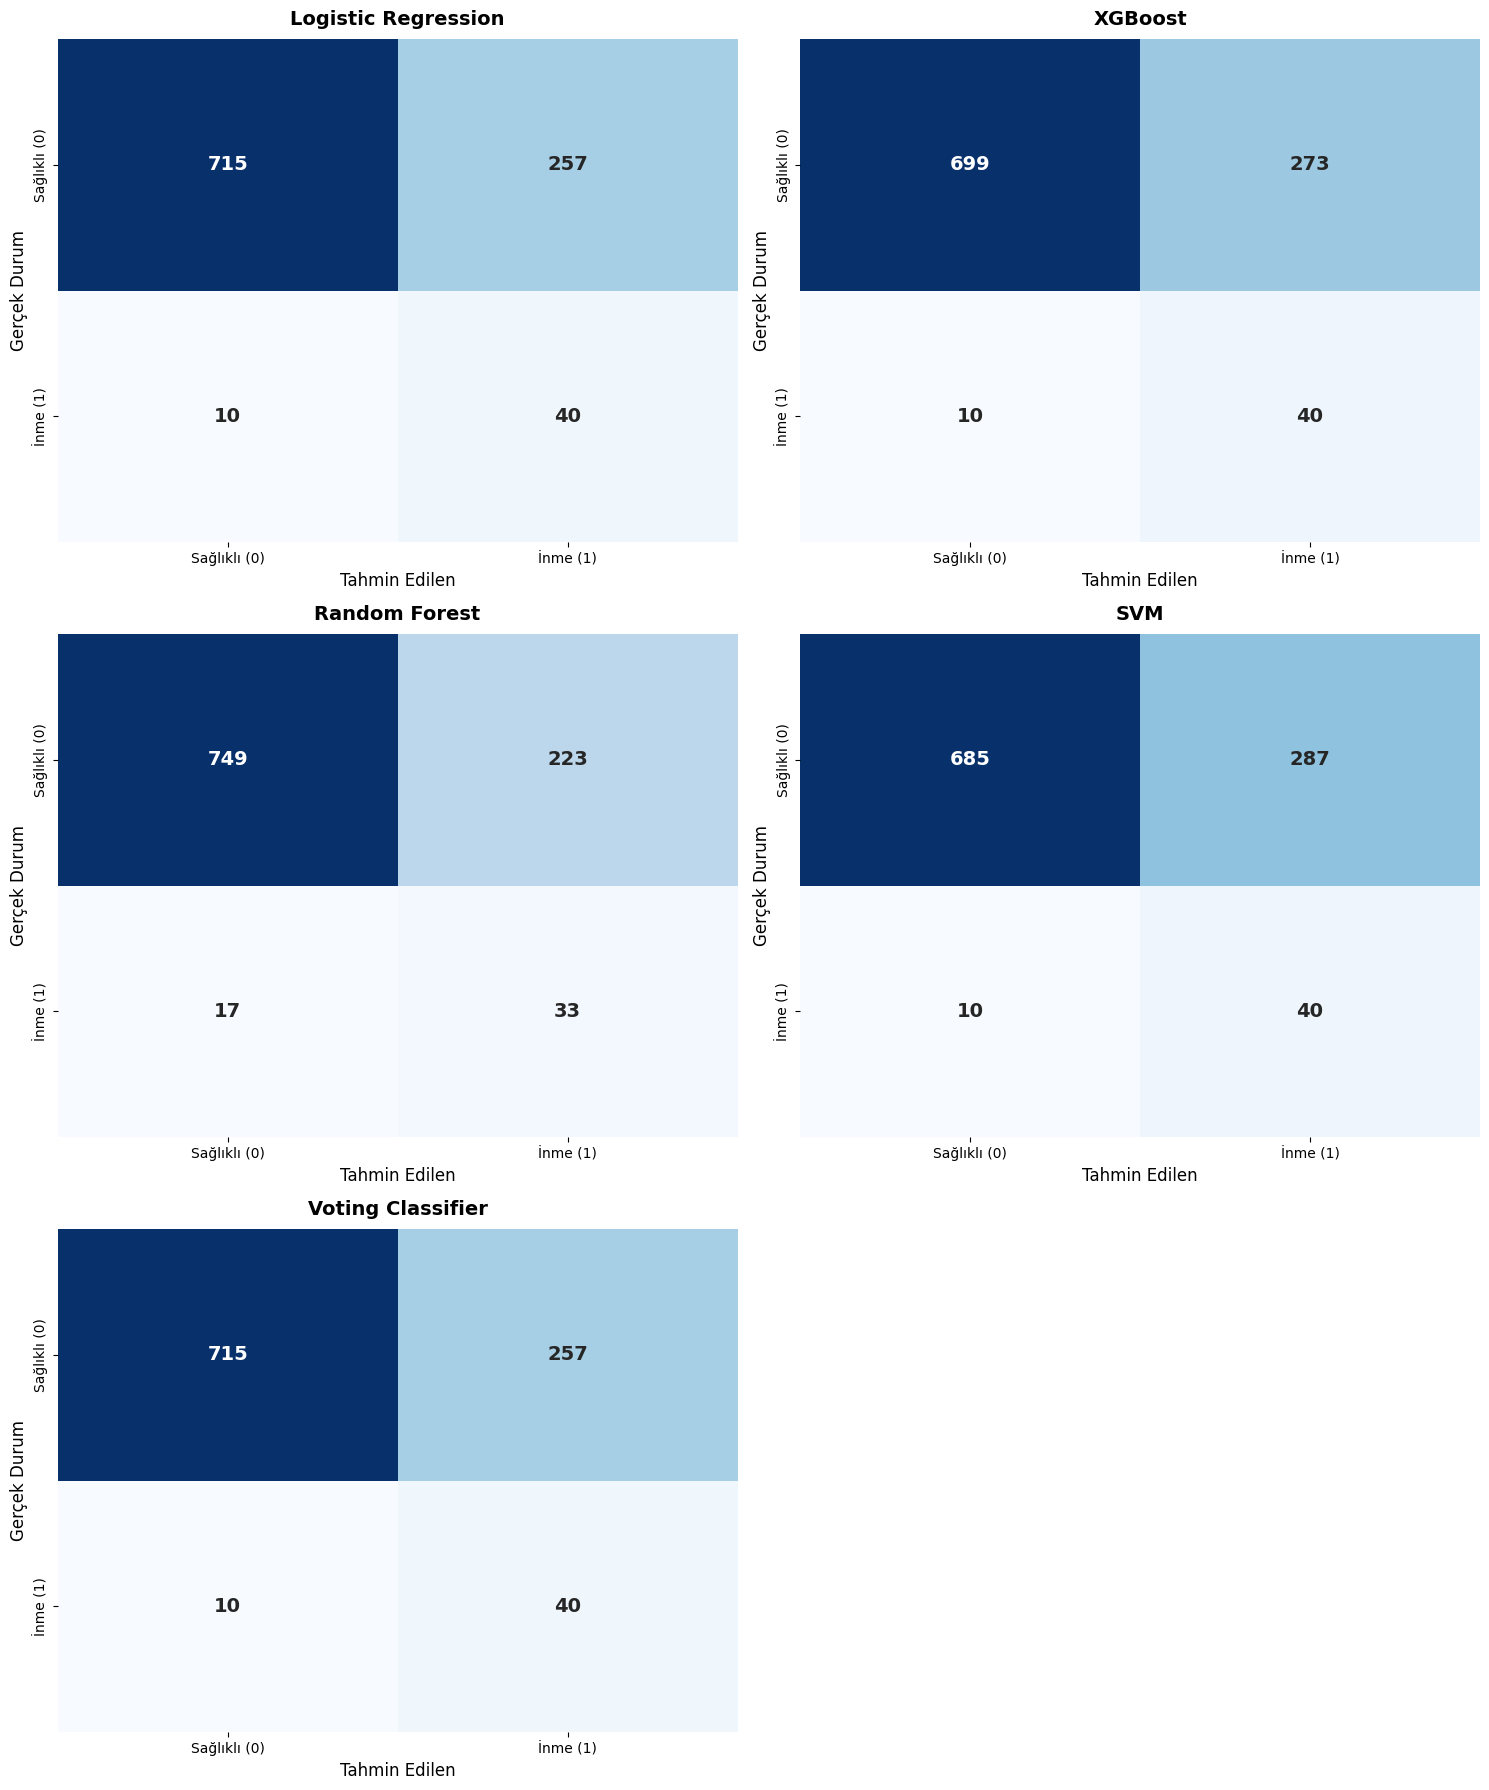

In [37]:
# Confusion Matrix
plt.figure(figsize=(15, 18))
n_models = len(trained_models)
rows = (n_models // 2) + (n_models % 2)

for i, (name, model) in enumerate(trained_models.items(), 1):
    plt.subplot(rows, 2, i)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                annot_kws={'size': 14, 'weight': 'bold'})
    plt.title(f'{name}', fontsize=14, fontweight='bold', pad=10)
    plt.xlabel('Tahmin Edilen', fontsize=12)
    plt.ylabel('Gerçek Durum', fontsize=12)
    plt.xticks([0.5, 1.5], ['Sağlıklı (0)', 'İnme (1)'])
    plt.yticks([0.5, 1.5], ['Sağlıklı (0)', 'İnme (1)'])

plt.tight_layout()
plt.show()

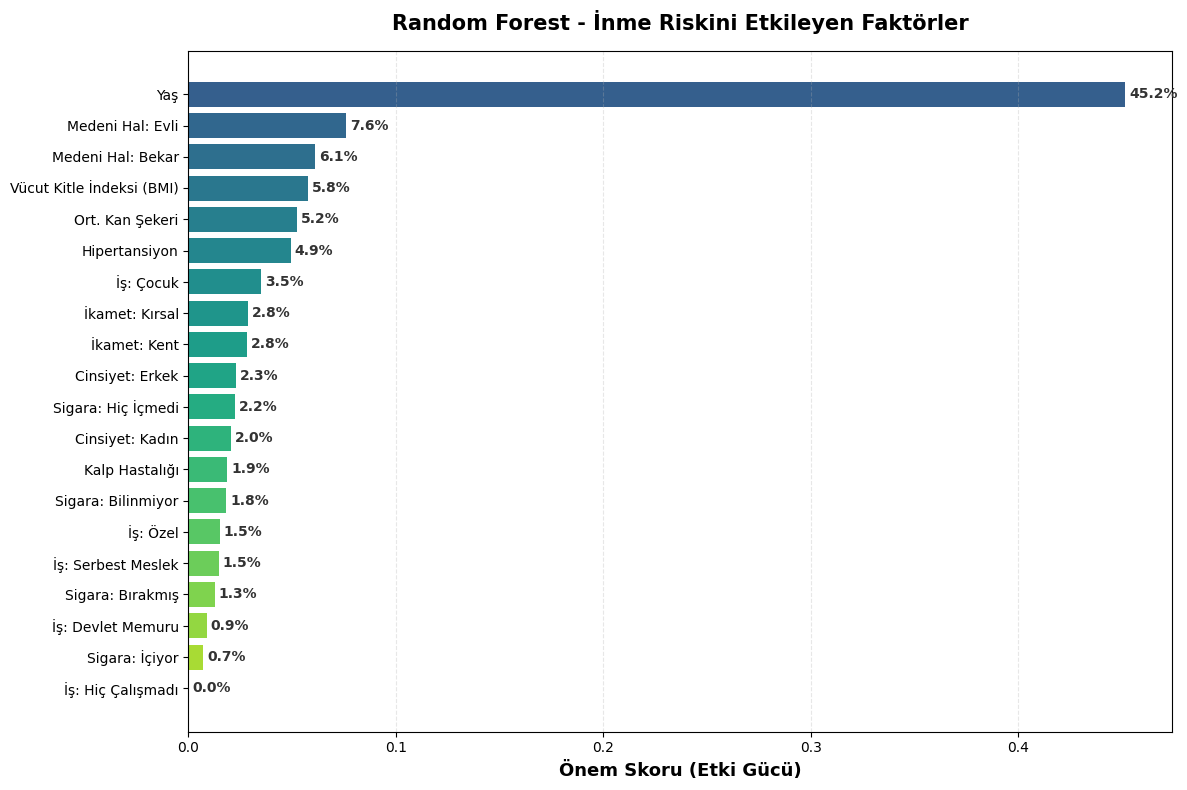


🏆 Random Forest En Önemli 5 Özellik (Türkçe):
  Yaş: 0.4516
  Medeni Hal: Evli: 0.0758
  Medeni Hal: Bekar: 0.0611
  Vücut Kitle İndeksi (BMI): 0.0577
  Ort. Kan Şekeri: 0.0524


In [38]:
rf_model = trained_models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.named_steps['classifier'].feature_importances_
}).sort_values('importance', ascending=False)

label_map = {
    'age': 'Yaş',
    'avg_glucose_level': 'Ort. Kan Şekeri',
    'bmi': 'Vücut Kitle İndeksi (BMI)',
    'hypertension': 'Hipertansiyon',
    'heart_disease': 'Kalp Hastalığı',
    'gender_0': 'Cinsiyet: Kadın',
    'gender_1': 'Cinsiyet: Erkek',
    'ever_married_0': 'Medeni Hal: Evli',
    'ever_married_1': 'Medeni Hal: Bekar',
    'work_type_0': 'İş: Özel',
    'work_type_1': 'İş: Serbest Meslek',
    'work_type_2': 'İş: Çocuk',
    'work_type_3': 'İş: Devlet Memuru',
    'work_type_4': 'İş: Hiç Çalışmadı',
    'Residence_type_0': 'İkamet: Kent',
    'Residence_type_1': 'İkamet: Kırsal',
    'smoking_status_0': 'Sigara: Hiç İçmedi',
    'smoking_status_1': 'Sigara: Bilinmiyor',
    'smoking_status_2': 'Sigara: Bırakmış',
    'smoking_status_3': 'Sigara: İçiyor'
}

feature_importance['readable_name'] = feature_importance['feature'].map(label_map).fillna(feature_importance['feature'])
plt.figure(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(feature_importance)))
bars = plt.barh(feature_importance['readable_name'], feature_importance['importance'], color=colors)

plt.xlabel('Önem Skoru (Etki Gücü)', fontsize=13, fontweight='bold')
plt.title('Random Forest - İnme Riskini Etkileyen Faktörler', fontsize=15, fontweight='bold', pad=15)
plt.gca().invert_yaxis()

for i, (bar, val) in enumerate(zip(bars, feature_importance['importance'])):
    plt.text(val + 0.002, bar.get_y() + bar.get_height()/2,
             f'{val:.1%}',
             va='center', fontsize=10, fontweight='bold', color='#333333')

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n🏆 Random Forest En Önemli 5 Özellik (Türkçe):")
for idx, row in feature_importance.head().iterrows():
    print(f"  {row['readable_name']}: {row['importance']:.4f}")

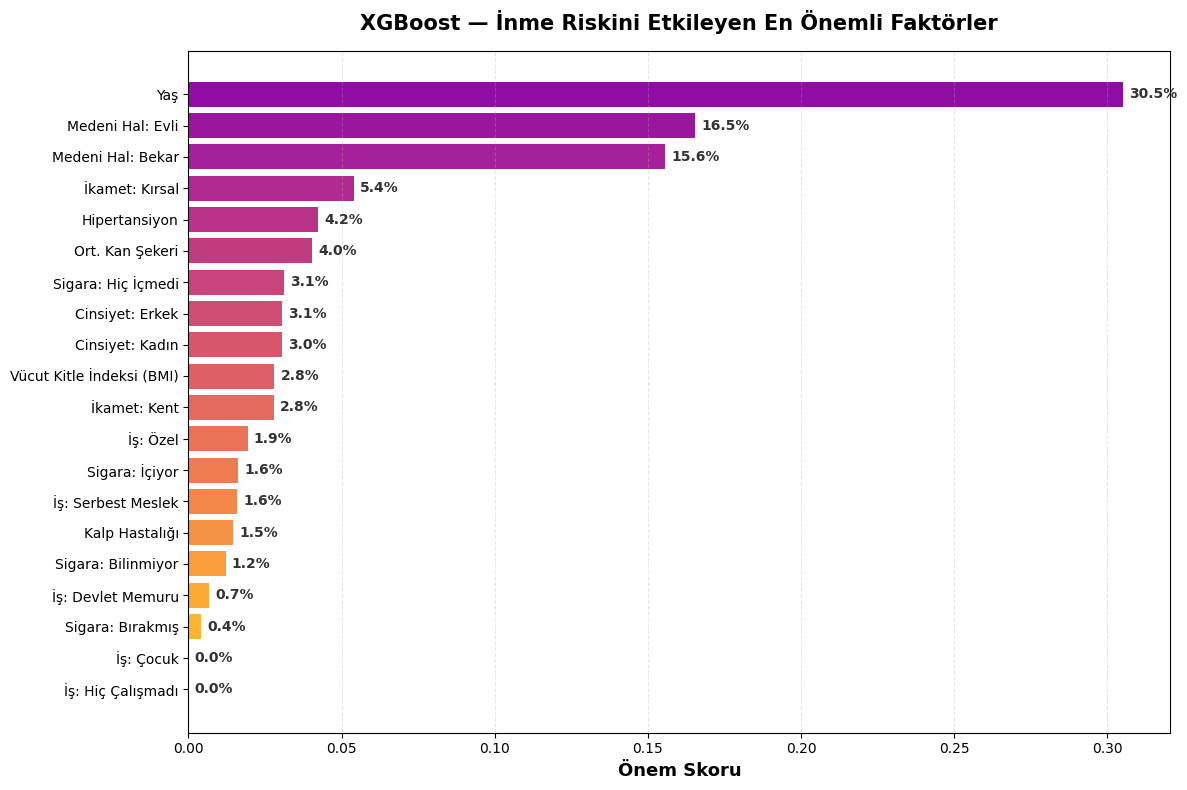


🏆 XGBoost — En Önemli 5 Özellik (Türkçe):
  Yaş: 0.3052
  Medeni Hal: Evli: 0.1653
  Medeni Hal: Bekar: 0.1557
  İkamet: Kırsal: 0.0540
  Hipertansiyon: 0.0424


In [39]:
xgb_model = trained_models['XGBoost']

xgb_importance = pd.DataFrame({
    "feature": X.columns,
    "importance": xgb_model.named_steps['classifier'].feature_importances_
}).sort_values(by="importance", ascending=False)

label_map = {
    'age': 'Yaş',
    'avg_glucose_level': 'Ort. Kan Şekeri',
    'bmi': 'Vücut Kitle İndeksi (BMI)',
    'hypertension': 'Hipertansiyon',
    'heart_disease': 'Kalp Hastalığı',
    'gender_0': 'Cinsiyet: Kadın',
    'gender_1': 'Cinsiyet: Erkek',
    'ever_married_0': 'Medeni Hal: Evli',
    'ever_married_1': 'Medeni Hal: Bekar',
    'work_type_0': 'İş: Özel',
    'work_type_1': 'İş: Serbest Meslek',
    'work_type_2': 'İş: Çocuk',
    'work_type_3': 'İş: Devlet Memuru',
    'work_type_4': 'İş: Hiç Çalışmadı',
    'Residence_type_0': 'İkamet: Kent',
    'Residence_type_1': 'İkamet: Kırsal',
    'smoking_status_0': 'Sigara: Hiç İçmedi',
    'smoking_status_1': 'Sigara: Bilinmiyor',
    'smoking_status_2': 'Sigara: Bırakmış',
    'smoking_status_3': 'Sigara: İçiyor'
}

xgb_importance['readable_name'] = xgb_importance['feature'].map(label_map).fillna(xgb_importance['feature'])
plt.figure(figsize=(12, 8))
bars = plt.barh(xgb_importance["readable_name"], xgb_importance["importance"],
                color=plt.cm.plasma(np.linspace(0.3, 0.9, len(xgb_importance))))

plt.xlabel("Önem Skoru", fontsize=13, fontweight="bold")
plt.title("XGBoost — İnme Riskini Etkileyen En Önemli Faktörler", fontsize=15, fontweight="bold", pad=15)
plt.gca().invert_yaxis()

for bar, val in zip(bars, xgb_importance["importance"]):
    plt.text(val + 0.002, bar.get_y() + bar.get_height()/2,
             f"{val:.1%}",
             va="center", fontsize=10, fontweight="bold", color='#333333')

plt.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

print("\n🏆 XGBoost — En Önemli 5 Özellik (Türkçe):")
for _, row in xgb_importance.head().iterrows():
    print(f"  {row['readable_name']}: {row['importance']:.4f}")

In [42]:
def yeni_hasta_tahmini():
    print("\n" + "="*80)
    print("🩺 İNME RİSKİ TAHMİN SİSTEMİ (İNTERAKTİF)")
    print("Lütfen hastanın değerlerini belirtilen aralıklarda giriniz.")
    print("="*80 + "\n")

    input_specs = {
        'age':               {'label': 'Yaş (0-120)', 'min': 0, 'max': 120},
        'avg_glucose_level': {'label': 'Ortalama Şeker Düzeyi (50-300)', 'min': 20, 'max': 300},
        'bmi':               {'label': 'Vücut Kitle İndeksi (BMI) (10-60)', 'min': 10, 'max': 60},
        'hypertension':      {'label': 'Hipertansiyon (1: Var, 0: Yok)', 'min': 0, 'max': 1},
        'heart_disease':     {'label': 'Kalp Hastalığı (1: Var, 0: Yok)', 'min': 0, 'max': 1},
        'gender':            {'label': 'Cinsiyet (1: Erkek, 0: Kadın)', 'min': 0, 'max': 1},
        'ever_married':      {'label': 'Evlilik Durumu (0: Evli, 1: Bekar)', 'min': 0, 'max': 1},
        'work_type':         {'label': 'İş (0:Özel, 1:Serbest, 2:Çocuk, 3:Memur, 4:Çalışmadı)', 'min': 0, 'max': 4},
        'Residence_type':    {'label': 'İkamet (0: Kent, 1: Kırsal)', 'min': 0, 'max': 1},
        'smoking_status':    {'label': 'Sigara (0:Hiç, 1:Bilinmiyor, 2:Bırakmış, 3:İçiyor)', 'min': 0, 'max': 3}
    }

    user_input = {}
    for col, specs in input_specs.items():
        while True:
            try:
                val_str = input(f"👉 {specs['label']:<65} giriniz: ")
                val = float(val_str)

                if specs['min'] <= val <= specs['max']:
                    user_input[col] = int(val) if val.is_integer() else val
                    break
                else:
                    print(f"   ⚠️ UYARI: Lütfen {specs['min']} ile {specs['max']} arasında bir değer giriniz!")
            except ValueError:
                print("   ❌ HATA: Lütfen geçerli bir sayı giriniz!")

    input_df = pd.DataFrame(0, index=[0], columns=X.columns)
    input_df['age'] = user_input['age']
    input_df['avg_glucose_level'] = user_input['avg_glucose_level']
    input_df['bmi'] = user_input['bmi']
    input_df['hypertension'] = user_input['hypertension']
    input_df['heart_disease'] = user_input['heart_disease']
    input_df[f"gender_{user_input['gender']}"] = 1
    input_df[f"ever_married_{user_input['ever_married']}"] = 1
    input_df[f"work_type_{user_input['work_type']}"] = 1
    input_df[f"Residence_type_{user_input['Residence_type']}"] = 1
    input_df[f"smoking_status_{user_input['smoking_status']}"] = 1

    try:
        new_data_scaled = scaler.transform(input_df)
    except Exception as e:
        print("\n❌ HATA: Scaler dönüşümünde sorun oluştu. Sütun isimleri uyuşmuyor olabilir.")
        print(f"Hata detayı: {e}")
        return

    print("\n" + "="*80)
    print("🤖 MODEL TAHMİN SONUÇLARI")
    print("="*80)
    print(f"{'Model Adı':<25} | {'Tahmin':<22} | {'Güven Oranı':<20}")
    print("-" * 65)


    if 'Voting Classifier' not in trained_models:
        trained_models['Voting Classifier'] = voting_clf

    for name, model in trained_models.items():

        try:
            prediction = model.predict(new_data_scaled)[0]
            if hasattr(model, "predict_proba"):
                prob_values = model.predict_proba(new_data_scaled)[0]
                guven = prob_values[prediction] * 100
            else:
                guven = 100.0 if prediction == 1 else 0.0

            if prediction == 1:
                durum = "İNME RİSKİ VAR 🚨"
                renk_kodu = "\033[91m"
            else:
                durum = "SAĞLIKLI ✅"
                renk_kodu = "\033[92m"

            print(f"{name:<25} | {durum:<20} | %{guven:.2f} Oran.")
        except Exception as e:
            print(f"{name:<25} | HATA OLUŞTU          | -")
1
yeni_hasta_tahmini()


🩺 İNME RİSKİ TAHMİN SİSTEMİ (İNTERAKTİF)
Lütfen hastanın değerlerini belirtilen aralıklarda giriniz.

👉 Yaş (0-120)                                                       giriniz: 72
👉 Ortalama Şeker Düzeyi (50-300)                                    giriniz: 230
👉 Vücut Kitle İndeksi (BMI) (10-60)                                 giriniz: 38.5
👉 Hipertansiyon (1: Var, 0: Yok)                                    giriniz: 1
👉 Kalp Hastalığı (1: Var, 0: Yok)                                   giriniz: 1
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 1
👉 Evlilik Durumu (0: Evli, 1: Bekar)                                giriniz: 0
👉 İş (0:Özel, 1:Serbest, 2:Çocuk, 3:Memur, 4:Çalışmadı)             giriniz: 0
👉 İkamet (0: Kent, 1: Kırsal)                                       giriniz: 0
👉 Sigara (0:Hiç, 1:Bilinmiyor, 2:Bırakmış, 3:İçiyor)                giriniz: 3

🤖 MODEL TAHMİN SONUÇLARI
Model Adı                 | Tahmin                 | Güven Oranı         
-

In [43]:
yeni_hasta_tahmini()


🩺 İNME RİSKİ TAHMİN SİSTEMİ (İNTERAKTİF)
Lütfen hastanın değerlerini belirtilen aralıklarda giriniz.

👉 Yaş (0-120)                                                       giriniz: 25
👉 Ortalama Şeker Düzeyi (50-300)                                    giriniz: 85
👉 Vücut Kitle İndeksi (BMI) (10-60)                                 giriniz: 22.4
👉 Hipertansiyon (1: Var, 0: Yok)                                    giriniz: 0
👉 Kalp Hastalığı (1: Var, 0: Yok)                                   giriniz: 0
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 0
👉 Evlilik Durumu (0: Evli, 1: Bekar)                                giriniz: 1
👉 İş (0:Özel, 1:Serbest, 2:Çocuk, 3:Memur, 4:Çalışmadı)             giriniz: 4
👉 İkamet (0: Kent, 1: Kırsal)                                       giriniz: 1
👉 Sigara (0:Hiç, 1:Bilinmiyor, 2:Bırakmış, 3:İçiyor)                giriniz: 0

🤖 MODEL TAHMİN SONUÇLARI
Model Adı                 | Tahmin                 | Güven Oranı         
--

In [44]:
yeni_hasta_tahmini()


🩺 İNME RİSKİ TAHMİN SİSTEMİ (İNTERAKTİF)
Lütfen hastanın değerlerini belirtilen aralıklarda giriniz.

👉 Yaş (0-120)                                                       giriniz: 55
👉 Ortalama Şeker Düzeyi (50-300)                                    giriniz: 115
👉 Vücut Kitle İndeksi (BMI) (10-60)                                 giriniz: 28.5
👉 Hipertansiyon (1: Var, 0: Yok)                                    giriniz: 0
👉 Kalp Hastalığı (1: Var, 0: Yok)                                   giriniz: 0
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 1
👉 Evlilik Durumu (0: Evli, 1: Bekar)                                giriniz: 0
👉 İş (0:Özel, 1:Serbest, 2:Çocuk, 3:Memur, 4:Çalışmadı)             giriniz: 0
👉 İkamet (0: Kent, 1: Kırsal)                                       giriniz: 0
👉 Sigara (0:Hiç, 1:Bilinmiyor, 2:Bırakmış, 3:İçiyor)                giriniz: 2

🤖 MODEL TAHMİN SONUÇLARI
Model Adı                 | Tahmin                 | Güven Oranı         
-

In [45]:
yeni_hasta_tahmini()


🩺 İNME RİSKİ TAHMİN SİSTEMİ (İNTERAKTİF)
Lütfen hastanın değerlerini belirtilen aralıklarda giriniz.

👉 Yaş (0-120)                                                       giriniz: 21
👉 Ortalama Şeker Düzeyi (50-300)                                    giriniz: 90
👉 Vücut Kitle İndeksi (BMI) (10-60)                                 giriniz: 24.78
👉 Hipertansiyon (1: Var, 0: Yok)                                    giriniz: 0
👉 Kalp Hastalığı (1: Var, 0: Yok)                                   giriniz: 0
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 1
👉 Evlilik Durumu (0: Evli, 1: Bekar)                                giriniz: 1
👉 İş (0:Özel, 1:Serbest, 2:Çocuk, 3:Memur, 4:Çalışmadı)             giriniz: 1
👉 İkamet (0: Kent, 1: Kırsal)                                       giriniz: 0
👉 Sigara (0:Hiç, 1:Bilinmiyor, 2:Bırakmış, 3:İçiyor)                giriniz: 0

🤖 MODEL TAHMİN SONUÇLARI
Model Adı                 | Tahmin                 | Güven Oranı         
-

In [47]:
yeni_hasta_tahmini()


🩺 İNME RİSKİ TAHMİN SİSTEMİ (İNTERAKTİF)
Lütfen hastanın değerlerini belirtilen aralıklarda giriniz.

👉 Yaş (0-120)                                                       giriniz: 66
👉 Ortalama Şeker Düzeyi (50-300)                                    giriniz: 120
👉 Vücut Kitle İndeksi (BMI) (10-60)                                 giriniz: 27.8
👉 Hipertansiyon (1: Var, 0: Yok)                                    giriniz: 0
👉 Kalp Hastalığı (1: Var, 0: Yok)                                   giriniz: 0
👉 Cinsiyet (1: Erkek, 0: Kadın)                                     giriniz: 1
👉 Evlilik Durumu (0: Evli, 1: Bekar)                                giriniz: 0
👉 İş (0:Özel, 1:Serbest, 2:Çocuk, 3:Memur, 4:Çalışmadı)             giriniz: 3
👉 İkamet (0: Kent, 1: Kırsal)                                       giriniz: 0
👉 Sigara (0:Hiç, 1:Bilinmiyor, 2:Bırakmış, 3:İçiyor)                giriniz: 3

🤖 MODEL TAHMİN SONUÇLARI
Model Adı                 | Tahmin                 | Güven Oranı         
-